In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from PIL import Image

class BaseDataProvider(object):

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_max is not None else np.inf
        self.channels = 1
        self.n_class = 2

    def get_channels(self):
      return self.channels

    def get_class_count(self):
        return self.n_class

    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx = train_data.shape[1]
        ny = train_data.shape[0]
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class))
            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we check here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        if np.amax(data) != 0:
            data /= np.amax(data)
        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
        return X, Y

class GrayScaleDataProvider(BaseDataProvider):

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.channels = 1
        self.n_class = 2
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

def create_image_and_label(nx, ny, cnt = 10, r_min = 2, r_max = 12, border = 13, sigma = 20):
    image = np.ones((nx, ny, 1), dtype=np.float32)
    label = np.zeros((nx, ny, 1), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(50, 255)
        y, x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)
        image[m] = h

    label[mask, 0] = 1
    image += np.random.normal(scale = sigma, size = image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    return image, label[..., 0]


In [3]:
nx = 64
ny = 64

In [4]:
generator = GrayScaleDataProvider(nx, ny, cnt = 20)

In [5]:
x_test_64, y_test_64 = generator(1)

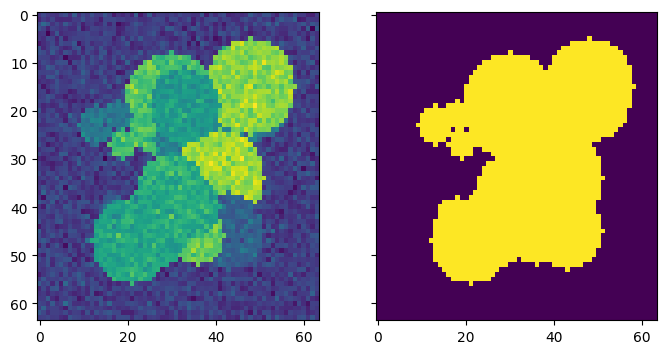

In [6]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax[0].imshow(x_test_64[0,...,0], aspect = "auto")
ax[1].imshow(y_test_64[0,...,1], aspect = "auto")

In [7]:
x_train_test_64, y_train_test_64 = generator(400)
print("x_train_test =", x_train_test_64.shape)
print("y_train_test =", y_train_test_64.shape)

x_train_test = (400, 64, 64, 1)
y_train_test = (400, 64, 64, 2)


In [8]:
nx = 128
ny = 128

In [9]:
generator = GrayScaleDataProvider(nx, ny, cnt = 20)

In [10]:
x_test_128, y_test_128 = generator(1)

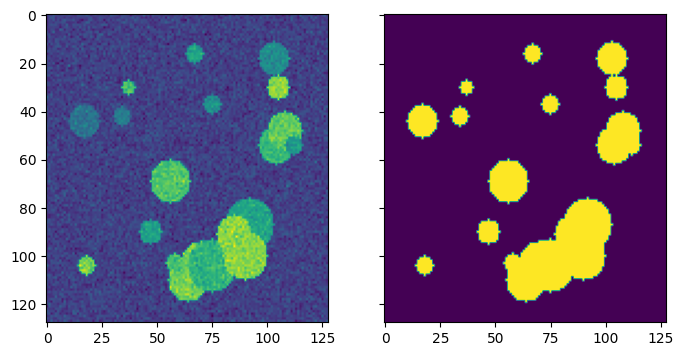

In [11]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax[0].imshow(x_test_128[0,...,0], aspect = "auto")
ax[1].imshow(y_test_128[0,...,1], aspect = "auto")

In [12]:
x_train_test_128, y_train_test_128 = generator(400)
print("x_train_test =", x_train_test_128.shape)
print("y_train_test =", y_train_test_128.shape)

x_train_test = (400, 128, 128, 1)
y_train_test = (400, 128, 128, 2)


In [13]:
img_channels = generator.get_channels()
class_count = generator.get_class_count()
RANDOM_SEED = 42
x_train_64, x_val_64, y_train_64, y_val_64 =  train_test_split(x_train_test_64, y_train_test_64, test_size = 0.25)
x_val_64, x_test_64, y_val_64, y_test_64 = train_test_split(x_val_64, y_val_64, test_size=0.5, random_state=RANDOM_SEED)
x_train_64 = x_train_64.transpose((0, 3, 1, 2))
y_train_64 = y_train_64.transpose((0, 3, 1, 2))
x_val_64 = x_val_64.transpose((0, 3, 1, 2))
y_val_64 = y_val_64.transpose((0, 3, 1, 2))
x_test_64 = x_test_64.transpose((0, 3, 1, 2))
y_test_64 = y_test_64.transpose((0, 3, 1, 2))

x_train_128, x_val_128, y_train_128, y_val_128 =  train_test_split(x_train_test_128, y_train_test_128, test_size=0.25)
x_val_128, x_test_128, y_val_128, y_test_128 = train_test_split(x_val_128, y_val_128, test_size=0.5, random_state=RANDOM_SEED)
x_train_128 = x_train_128.transpose((0, 3, 1, 2))
y_train_128 = y_train_128.transpose((0, 3, 1, 2))
x_val_128 = x_val_128.transpose((0, 3, 1, 2))
y_val_128 = y_val_128.transpose((0, 3, 1, 2))
x_test_128 = x_test_128.transpose((0, 3, 1, 2))
y_test_128 = y_test_128.transpose((0, 3, 1, 2))

In [14]:
epochs = 20
epoch_lapse = 1
threshold = 0.33
sample_size = None

In [15]:
class UNet2(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size = 3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels = mid_channel, out_channels = out_channels, kernel_size = 3, stride=2, padding=1, output_padding=1)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size = 3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = out_channels, padding=1),
                    torch.nn.Sigmoid(),
                    )
            return  block

    def __init__(self, in_channel, out_channel, k_size = 3):
        super(UNet2, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels = in_channel, out_channels = 64, kernel_size = k_size)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode4 = self.contracting_block(64, 512, kernel_size = k_size)
        self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size = 2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 1024, padding = 1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.Conv2d(kernel_size = 3, in_channels = 1024, out_channels = 1024, padding = 1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode4 = self.expansive_block(1024, 128, 64, kernel_size = k_size)
        self.final_layer = self.final_block(128, 64, out_channel, kernel_size = k_size)

    def crop_and_concat(self, upsampled, bypass, crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block4 = self.conv_encode4(encode_pool1)
        encode_pool4  = self.conv_maxpool4(encode_block4)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool4)
        # Decode
        decode_block4 = self.crop_and_concat(bottleneck1, encode_block4, crop=True)
        cat_layer3 = self.conv_decode4(decode_block4)
        decode_block1 = self.crop_and_concat(cat_layer3, encode_block1, crop=True)
        #print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        #print(final_layer.shape)
        return  final_layer

In [16]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size = 3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = out_channels, out_channels = out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size = 3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels = mid_channel, out_channels = out_channels, kernel_size = 3, stride=2, padding=1, output_padding=1)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size = 3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = in_channels, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout2d(),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size = kernel_size, in_channels = mid_channel, out_channels = out_channels, padding=1),
                    torch.nn.Sigmoid(),
                    )
            return  block

    def __init__(self, in_channel, out_channel, k_size = 3):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels = in_channel, out_channels = 64, kernel_size = k_size)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode2 = self.contracting_block(64, 128, kernel_size = k_size)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode3 = self.contracting_block(128, 256, kernel_size = k_size)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size = 2)
        self.conv_encode4 = self.contracting_block(256, 512, kernel_size = k_size)
        self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size = 2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 1024, padding = 1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.Conv2d(kernel_size = 3, in_channels = 1024, out_channels = 1024, padding = 1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(1024),
                            torch.nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 3, stride = 2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode4 = self.expansive_block(1024, 512, 256, kernel_size = k_size)
        self.conv_decode3 = self.expansive_block(512, 256, 128, kernel_size = k_size)
        self.conv_decode2 = self.expansive_block(256, 128, 64, kernel_size = k_size)
        self.final_layer = self.final_block(128, 64, out_channel, kernel_size = k_size)

    def crop_and_concat(self, upsampled, bypass, crop = False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        #print(encode_block1.shape)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        encode_block4 = self.conv_encode4(encode_pool3)
        encode_pool4  = self.conv_maxpool4(encode_block4)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool4)
        # Decode
        #print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, encode_pool3.shape, bottleneck1.shape)
        #print('Decode Block 3')
        #print(bottleneck1.shape, encode_block3.shape)
        decode_block4 = self.crop_and_concat(bottleneck1, encode_block4, crop=True)
        cat_layer3 = self.conv_decode4(decode_block4)
        decode_block3 = self.crop_and_concat(cat_layer3, encode_block3, crop=True)
        #print(decode_block3.shape)
        #print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        #print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        #print(cat_layer1.shape, encode_block1.shape)
        #print('Final Layer')
        #print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        #print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        #print(final_layer.shape)
        return  final_layer

In [17]:
def train_step(unet, inputs, labels, optimizer, criterion, width_out, height_out, batch_size):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, class_count)
    #print(outputs.shape)
    outputs = outputs.reshape(batch_size*width_out*height_out, class_count)
    labels = labels.reshape(batch_size*width_out*height_out, class_count)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [18]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [19]:
set_seed()

In [20]:
criterion = nn.BCEWithLogitsLoss()

In [21]:
def get_val_loss(unet, x_val, y_val, width_out, height_out, batch_size = 1):
    unet.eval()
    epoch_iter = x_val.shape[0] // batch_size
    total_loss = 0
    val_accuracy = 0
    for i in range(epoch_iter):
        batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size]).float()
        batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size].astype(int)).float()
        batch_val_x = batch_val_x.to(device)
        batch_val_y = batch_val_y.to(device)
        outputs = unet(batch_val_x)
        outputs = outputs.permute(0, 2, 3, 1)
        outputs = outputs.reshape(batch_size*width_out*height_out, class_count)
        labels = batch_val_y.reshape(batch_size*width_out*height_out, class_count)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        thresholded_outputs = torch.gt(outputs, 0.5)
        correct_pixels = (thresholded_outputs == labels).sum().item()
        val_accuracy += correct_pixels/(outputs.shape[0]*outputs.shape[1])
        gc.collect()
    return total_loss / epoch_iter, val_accuracy / epoch_iter

In [22]:
def train(unet, x_train, y_train, x_val, y_val, optimizer, width_out, height_out, batch_size):
    epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
    t = trange(epochs, leave=True)
    for _ in t:
        total_loss = 0
        unet.train()
        for i in range(epoch_iter):
            batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
            batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size].astype(int)).float()
            batch_train_x = batch_train_x.to(device)
            batch_train_y = batch_train_y.to(device)
            batch_loss = train_step(unet, batch_train_x , batch_train_y, optimizer, criterion, width_out, height_out, batch_size)
            total_loss += batch_loss
            gc.collect()
        if (_+1) % epoch_lapse == 0:
            val_loss, val_accuracy = get_val_loss(unet, x_val, y_val, width_out, height_out, batch_size)
            print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss} validation accuracy : {val_accuracy}")

In [23]:
width_out = 64
height_out = 64

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1 = torch.optim.AdamW(unet.parameters(), lr = 0.01)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer1, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet (64x64 dataset optimizer1 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1 = torch.optim.AdamW(unet.parameters(), lr = 0.01)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer1, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet (64x64 dataset optimizer1 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.01)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer1_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet_2 (64x64 dataset optimizer1_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.01)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer1_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet_2 (64x64 dataset optimizer1_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet64_opt1.pt')

  5%|▌         | 1/20 [00:18<05:58, 18.85s/it]

Total loss in epoch 1 : 0.677823543548584 and validation loss : 0.6707691848278046 validation accuracy : 0.5691019694010416


 10%|█         | 2/20 [00:30<04:25, 14.75s/it]

Total loss in epoch 2 : 0.6653247475624084 and validation loss : 0.6606106261412302 validation accuracy : 0.5943044026692709


 15%|█▌        | 3/20 [00:42<03:44, 13.19s/it]

Total loss in epoch 3 : 0.6545241475105286 and validation loss : 0.6445404440164566 validation accuracy : 0.64349365234375


 20%|██        | 4/20 [00:52<03:16, 12.28s/it]

Total loss in epoch 4 : 0.6358450651168823 and validation loss : 0.6224162230889002 validation accuracy : 0.7099380493164062


 25%|██▌       | 5/20 [01:03<02:56, 11.80s/it]

Total loss in epoch 5 : 0.6018310785293579 and validation loss : 0.5820688406626383 validation accuracy : 0.8205769856770834


 30%|███       | 6/20 [01:15<02:45, 11.82s/it]

Total loss in epoch 6 : 0.5829154849052429 and validation loss : 0.5799231777588526 validation accuracy : 0.8300603230794271


 35%|███▌      | 7/20 [01:26<02:30, 11.54s/it]

Total loss in epoch 7 : 0.5806273818016052 and validation loss : 0.5785949925581614 validation accuracy : 0.8322016398111979


 40%|████      | 8/20 [01:37<02:17, 11.44s/it]

Total loss in epoch 8 : 0.5800834894180298 and validation loss : 0.5788284689188004 validation accuracy : 0.8287073771158854


 45%|████▌     | 9/20 [01:48<02:04, 11.31s/it]

Total loss in epoch 9 : 0.5795571804046631 and validation loss : 0.5785733113686243 validation accuracy : 0.8311487833658854


 50%|█████     | 10/20 [01:59<01:52, 11.21s/it]

Total loss in epoch 10 : 0.5795823335647583 and validation loss : 0.5778656254212061 validation accuracy : 0.8344014485677084


 55%|█████▌    | 11/20 [02:11<01:41, 11.23s/it]

Total loss in epoch 11 : 0.5797697305679321 and validation loss : 0.577380379041036 validation accuracy : 0.8359934488932291


 60%|██████    | 12/20 [02:22<01:29, 11.23s/it]

Total loss in epoch 12 : 0.5794301629066467 and validation loss : 0.5780755827824274 validation accuracy : 0.8341039021809896


 65%|██████▌   | 13/20 [02:33<01:18, 11.18s/it]

Total loss in epoch 13 : 0.5792087316513062 and validation loss : 0.5789623260498047 validation accuracy : 0.8270645141601562


 70%|███████   | 14/20 [02:44<01:07, 11.19s/it]

Total loss in epoch 14 : 0.5788799524307251 and validation loss : 0.576939677198728 validation accuracy : 0.8374888102213541


 75%|███████▌  | 15/20 [02:55<00:55, 11.15s/it]

Total loss in epoch 15 : 0.5777683854103088 and validation loss : 0.5750160863002142 validation accuracy : 0.8403981526692709


 80%|████████  | 16/20 [03:06<00:44, 11.10s/it]

Total loss in epoch 16 : 0.5757630467414856 and validation loss : 0.5764151314894358 validation accuracy : 0.8383255004882812


 85%|████████▌ | 17/20 [03:17<00:33, 11.09s/it]

Total loss in epoch 17 : 0.5747846364974976 and validation loss : 0.5725438098112742 validation accuracy : 0.855926513671875


 90%|█████████ | 18/20 [03:29<00:22, 11.27s/it]

Total loss in epoch 18 : 0.572155237197876 and validation loss : 0.5709290305773417 validation accuracy : 0.8547515869140625


 95%|█████████▌| 19/20 [03:40<00:11, 11.32s/it]

Total loss in epoch 19 : 0.5695561766624451 and validation loss : 0.5738975952068964 validation accuracy : 0.8457107543945312


100%|██████████| 20/20 [03:52<00:00, 11.60s/it]

Total loss in epoch 20 : 0.5669044852256775 and validation loss : 0.5655485192934672 validation accuracy : 0.8625768025716146


Test loss for unet (64x64 dataset optimizer1 batch_size=4): 0.5685361872116724 test accuracy: 0.8566818237304688


  5%|▌         | 1/20 [00:02<00:52,  2.77s/it]

Total loss in epoch 1 : 0.6866904497146606 and validation loss : 0.6672565340995789 validation accuracy : 0.5728088378906251


 10%|█         | 2/20 [00:05<00:45,  2.54s/it]

Total loss in epoch 2 : 0.6650480031967163 and validation loss : 0.6588732302188873 validation accuracy : 0.6179840087890625


 15%|█▌        | 3/20 [00:07<00:42,  2.47s/it]

Total loss in epoch 3 : 0.6554281115531921 and validation loss : 0.6477876305580139 validation accuracy : 0.648712158203125


 20%|██        | 4/20 [00:09<00:38,  2.44s/it]

Total loss in epoch 4 : 0.6378178000450134 and validation loss : 0.6132851243019104 validation accuracy : 0.7455841064453125


 25%|██▌       | 5/20 [00:12<00:37,  2.48s/it]

Total loss in epoch 5 : 0.6097474098205566 and validation loss : 0.5884310901165009 validation accuracy : 0.8167083740234375


 30%|███       | 6/20 [00:15<00:35,  2.53s/it]

Total loss in epoch 6 : 0.5860491991043091 and validation loss : 0.5794176757335663 validation accuracy : 0.839056396484375


 35%|███▌      | 7/20 [00:17<00:32,  2.49s/it]

Total loss in epoch 7 : 0.5812785029411316 and validation loss : 0.577025830745697 validation accuracy : 0.8404449462890624


 40%|████      | 8/20 [00:19<00:29,  2.46s/it]

Total loss in epoch 8 : 0.5798929929733276 and validation loss : 0.5767450332641602 validation accuracy : 0.839508056640625


 45%|████▌     | 9/20 [00:22<00:26,  2.44s/it]

Total loss in epoch 9 : 0.5793028473854065 and validation loss : 0.5768797695636749 validation accuracy : 0.838775634765625


 50%|█████     | 10/20 [00:25<00:25,  2.52s/it]

Total loss in epoch 10 : 0.5793781876564026 and validation loss : 0.5773504674434662 validation accuracy : 0.8413024902343751


 55%|█████▌    | 11/20 [00:27<00:22,  2.53s/it]

Total loss in epoch 11 : 0.5787187814712524 and validation loss : 0.5760025680065155 validation accuracy : 0.8416351318359375


 60%|██████    | 12/20 [00:29<00:19,  2.49s/it]

Total loss in epoch 12 : 0.5790345072746277 and validation loss : 0.5756492614746094 validation accuracy : 0.8408843994140625


 65%|██████▌   | 13/20 [00:32<00:17,  2.47s/it]

Total loss in epoch 13 : 0.5788492560386658 and validation loss : 0.5751169621944427 validation accuracy : 0.83970947265625


 70%|███████   | 14/20 [00:34<00:14,  2.45s/it]

Total loss in epoch 14 : 0.5776646137237549 and validation loss : 0.5750739276409149 validation accuracy : 0.8401214599609375


 75%|███████▌  | 15/20 [00:37<00:12,  2.53s/it]

Total loss in epoch 15 : 0.5769976377487183 and validation loss : 0.5737482011318207 validation accuracy : 0.8422607421875


 80%|████████  | 16/20 [00:39<00:10,  2.51s/it]

Total loss in epoch 16 : 0.5755831599235535 and validation loss : 0.5738688409328461 validation accuracy : 0.8449859619140625


 85%|████████▌ | 17/20 [00:42<00:07,  2.49s/it]

Total loss in epoch 17 : 0.5750317573547363 and validation loss : 0.5716095566749573 validation accuracy : 0.84951171875


 90%|█████████ | 18/20 [00:44<00:04,  2.47s/it]

Total loss in epoch 18 : 0.5728433132171631 and validation loss : 0.5701268911361694 validation accuracy : 0.8522216796875


 95%|█████████▌| 19/20 [00:47<00:02,  2.46s/it]

Total loss in epoch 19 : 0.5704821348190308 and validation loss : 0.565402626991272 validation accuracy : 0.8579925537109374


100%|██████████| 20/20 [00:50<00:00,  2.50s/it]

Total loss in epoch 20 : 0.5676032304763794 and validation loss : 0.5623205900192261 validation accuracy : 0.8671539306640625


Test loss for unet (64x64 dataset optimizer1 batch_size=20): 0.5672797560691833 test accuracy: 0.8577880859375


  5%|▌         | 1/20 [00:11<03:31, 11.13s/it]

Total loss in epoch 1 : 0.6732620596885681 and validation loss : 0.6675029098987579 validation accuracy : 0.6069005330403646


 10%|█         | 2/20 [00:21<03:14, 10.82s/it]

Total loss in epoch 2 : 0.6620733141899109 and validation loss : 0.6601979583501816 validation accuracy : 0.623565673828125


 15%|█▌        | 3/20 [00:32<03:04, 10.87s/it]

Total loss in epoch 3 : 0.6578402519226074 and validation loss : 0.656163732210795 validation accuracy : 0.6362406412760416


 20%|██        | 4/20 [00:43<02:55, 10.99s/it]

Total loss in epoch 4 : 0.6483781337738037 and validation loss : 0.6403339852889379 validation accuracy : 0.6698354085286459


 25%|██▌       | 5/20 [00:54<02:45, 11.04s/it]

Total loss in epoch 5 : 0.6339277029037476 and validation loss : 0.628778318564097 validation accuracy : 0.7041447957356771


 30%|███       | 6/20 [01:06<02:35, 11.08s/it]

Total loss in epoch 6 : 0.625536322593689 and validation loss : 0.6237606306870779 validation accuracy : 0.7160110473632812


 35%|███▌      | 7/20 [01:17<02:24, 11.08s/it]

Total loss in epoch 7 : 0.621905505657196 and validation loss : 0.6187406480312347 validation accuracy : 0.7197672526041666


 40%|████      | 8/20 [01:28<02:13, 11.13s/it]

Total loss in epoch 8 : 0.6171187162399292 and validation loss : 0.6152491023143133 validation accuracy : 0.7314427693684896


 45%|████▌     | 9/20 [01:39<02:01, 11.07s/it]

Total loss in epoch 9 : 0.6148974299430847 and validation loss : 0.6142047097285589 validation accuracy : 0.7381795247395834


 50%|█████     | 10/20 [01:50<01:50, 11.08s/it]

Total loss in epoch 10 : 0.611201286315918 and validation loss : 0.6089329769213995 validation accuracy : 0.74822998046875


 55%|█████▌    | 11/20 [02:02<01:40, 11.21s/it]

Total loss in epoch 11 : 0.6085746884346008 and validation loss : 0.6073724826176962 validation accuracy : 0.7536849975585938


 60%|██████    | 12/20 [02:13<01:29, 11.20s/it]

Total loss in epoch 12 : 0.6065384149551392 and validation loss : 0.6045270562171936 validation accuracy : 0.7576955159505209


 65%|██████▌   | 13/20 [02:24<01:17, 11.12s/it]

Total loss in epoch 13 : 0.6035629510879517 and validation loss : 0.6061908354361852 validation accuracy : 0.751495361328125


 70%|███████   | 14/20 [02:35<01:06, 11.10s/it]

Total loss in epoch 14 : 0.6013981699943542 and validation loss : 0.6004268030325571 validation accuracy : 0.7754618326822916


 75%|███████▌  | 15/20 [02:45<00:54, 10.93s/it]

Total loss in epoch 15 : 0.5979109406471252 and validation loss : 0.5981368621190389 validation accuracy : 0.7795282999674479


 80%|████████  | 16/20 [02:57<00:44, 11.20s/it]

Total loss in epoch 16 : 0.596407949924469 and validation loss : 0.595633531610171 validation accuracy : 0.7867914835611979


 85%|████████▌ | 17/20 [03:08<00:33, 11.08s/it]

Total loss in epoch 17 : 0.5932628512382507 and validation loss : 0.5945389121770859 validation accuracy : 0.7913004557291666


 90%|█████████ | 18/20 [03:19<00:22, 11.03s/it]

Total loss in epoch 18 : 0.5916935801506042 and validation loss : 0.5929679969946543 validation accuracy : 0.7947235107421875


 95%|█████████▌| 19/20 [03:30<00:11, 11.00s/it]

Total loss in epoch 19 : 0.5904176831245422 and validation loss : 0.5918570359547933 validation accuracy : 0.7900314331054688


100%|██████████| 20/20 [03:41<00:00, 11.05s/it]

Total loss in epoch 20 : 0.5882276296615601 and validation loss : 0.5898348540067673 validation accuracy : 0.7999954223632812


Test loss for unet_2 (64x64 dataset optimizer1_2 batch_size=4): 0.5910330216089884 test accuracy: 0.7971649169921875


  5%|▌         | 1/20 [00:06<02:01,  6.42s/it]

Total loss in epoch 1 : 0.6873683929443359 and validation loss : 0.6758588254451752 validation accuracy : 0.5614166259765625


 10%|█         | 2/20 [00:11<01:42,  5.67s/it]

Total loss in epoch 2 : 0.6655442714691162 and validation loss : 0.6573147773742676 validation accuracy : 0.6218414306640625


 15%|█▌        | 3/20 [00:16<01:33,  5.48s/it]

Total loss in epoch 3 : 0.6608044505119324 and validation loss : 0.655068427324295 validation accuracy : 0.6356689453125


 20%|██        | 4/20 [00:22<01:25,  5.36s/it]

Total loss in epoch 4 : 0.6556989550590515 and validation loss : 0.6515241861343384 validation accuracy : 0.6365631103515625


 25%|██▌       | 5/20 [00:27<01:19,  5.33s/it]

Total loss in epoch 5 : 0.6524840593338013 and validation loss : 0.6475380957126617 validation accuracy : 0.6504180908203125


 30%|███       | 6/20 [00:32<01:14,  5.29s/it]

Total loss in epoch 6 : 0.6470237374305725 and validation loss : 0.6441935002803802 validation accuracy : 0.6577819824218749


 35%|███▌      | 7/20 [00:37<01:08,  5.28s/it]

Total loss in epoch 7 : 0.6431213617324829 and validation loss : 0.6387223303318024 validation accuracy : 0.665228271484375


 40%|████      | 8/20 [00:42<01:03,  5.27s/it]

Total loss in epoch 8 : 0.6398935914039612 and validation loss : 0.6347068548202515 validation accuracy : 0.6786773681640625


 45%|████▌     | 9/20 [00:48<00:57,  5.26s/it]

Total loss in epoch 9 : 0.6347901821136475 and validation loss : 0.6291453242301941 validation accuracy : 0.6978088378906251


 50%|█████     | 10/20 [00:53<00:52,  5.27s/it]

Total loss in epoch 10 : 0.6313674449920654 and validation loss : 0.6292255818843842 validation accuracy : 0.6987274169921875


 55%|█████▌    | 11/20 [00:58<00:47,  5.27s/it]

Total loss in epoch 11 : 0.6283544898033142 and validation loss : 0.6236854195594788 validation accuracy : 0.7087921142578125


 60%|██████    | 12/20 [01:04<00:42,  5.29s/it]

Total loss in epoch 12 : 0.6267396211624146 and validation loss : 0.6217702031135559 validation accuracy : 0.7141632080078124


 65%|██████▌   | 13/20 [01:09<00:37,  5.29s/it]

Total loss in epoch 13 : 0.6233704686164856 and validation loss : 0.6190764307975769 validation accuracy : 0.71624755859375


 70%|███████   | 14/20 [01:14<00:31,  5.29s/it]

Total loss in epoch 14 : 0.6218744516372681 and validation loss : 0.6190387606620789 validation accuracy : 0.72152099609375


 75%|███████▌  | 15/20 [01:19<00:26,  5.29s/it]

Total loss in epoch 15 : 0.6204679608345032 and validation loss : 0.6165575385093689 validation accuracy : 0.7204650878906249


 80%|████████  | 16/20 [01:25<00:21,  5.28s/it]

Total loss in epoch 16 : 0.6181050539016724 and validation loss : 0.6150327622890472 validation accuracy : 0.72969970703125


 85%|████████▌ | 17/20 [01:30<00:15,  5.27s/it]

Total loss in epoch 17 : 0.6161726117134094 and validation loss : 0.6110200583934784 validation accuracy : 0.737213134765625


 90%|█████████ | 18/20 [01:35<00:10,  5.27s/it]

Total loss in epoch 18 : 0.6128419041633606 and validation loss : 0.611894965171814 validation accuracy : 0.7457061767578126


 95%|█████████▌| 19/20 [01:41<00:05,  5.30s/it]

Total loss in epoch 19 : 0.6097813248634338 and validation loss : 0.6063167154788971 validation accuracy : 0.7500579833984375


100%|██████████| 20/20 [01:46<00:00,  5.32s/it]

Total loss in epoch 20 : 0.6077471971511841 and validation loss : 0.6040326952934265 validation accuracy : 0.7571380615234375


Test loss for unet_2 (64x64 dataset optimizer1_2 batch_size=20): 0.6051245331764221 test accuracy: 0.754766845703125


In [24]:
unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2 = torch.optim.AdamW(unet.parameters(), lr = 0.005)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet (64x64 dataset optimizer2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2 = torch.optim.AdamW(unet.parameters(), lr = 0.005)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet (64x64 datase optimizer2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.005)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer2_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet_2 (64x64 dataset optimizer2_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.005)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer2_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet_2 (64x64 dataset optimizer2_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet64_opt2.pt')

  5%|▌         | 1/20 [00:11<03:37, 11.46s/it]

Total loss in epoch 1 : 0.6593433022499084 and validation loss : 0.6357727299133936 validation accuracy : 0.6795120239257812


 10%|█         | 2/20 [00:22<03:25, 11.42s/it]

Total loss in epoch 2 : 0.6235407590866089 and validation loss : 0.6051736871401469 validation accuracy : 0.7634785970052084


 15%|█▌        | 3/20 [00:34<03:14, 11.42s/it]

Total loss in epoch 3 : 0.5940200090408325 and validation loss : 0.5801647504170736 validation accuracy : 0.8329518636067709


 20%|██        | 4/20 [00:45<03:02, 11.43s/it]

Total loss in epoch 4 : 0.5808488726615906 and validation loss : 0.5787184635798136 validation accuracy : 0.8337961832682291


 25%|██▌       | 5/20 [00:57<02:52, 11.51s/it]

Total loss in epoch 5 : 0.5801379680633545 and validation loss : 0.5795698016881943 validation accuracy : 0.8289922078450521


 30%|███       | 6/20 [01:08<02:41, 11.52s/it]

Total loss in epoch 6 : 0.58005291223526 and validation loss : 0.5788972576459249 validation accuracy : 0.8319574991861979


 35%|███▌      | 7/20 [01:20<02:29, 11.53s/it]

Total loss in epoch 7 : 0.5792803168296814 and validation loss : 0.5787434627612432 validation accuracy : 0.8316828409830729


 40%|████      | 8/20 [01:32<02:18, 11.54s/it]

Total loss in epoch 8 : 0.5793242454528809 and validation loss : 0.5786187648773193 validation accuracy : 0.8291549682617188


 45%|████▌     | 9/20 [01:43<02:06, 11.53s/it]

Total loss in epoch 9 : 0.5790445804595947 and validation loss : 0.5784099201361338 validation accuracy : 0.8310292561848959


 50%|█████     | 10/20 [01:55<01:55, 11.52s/it]

Total loss in epoch 10 : 0.5789458751678467 and validation loss : 0.5781465520461401 validation accuracy : 0.8295313517252604


 55%|█████▌    | 11/20 [02:06<01:43, 11.52s/it]

Total loss in epoch 11 : 0.5786134004592896 and validation loss : 0.5780365914106369 validation accuracy : 0.8315963745117188


 60%|██████    | 12/20 [02:17<01:31, 11.40s/it]

Total loss in epoch 12 : 0.5782000422477722 and validation loss : 0.5758165468772253 validation accuracy : 0.8384679158528646


 65%|██████▌   | 13/20 [02:29<01:19, 11.41s/it]

Total loss in epoch 13 : 0.5759463310241699 and validation loss : 0.5750144769748052 validation accuracy : 0.8424428304036459


 70%|███████   | 14/20 [02:40<01:08, 11.41s/it]

Total loss in epoch 14 : 0.572806715965271 and validation loss : 0.5744932393232981 validation accuracy : 0.8491948445638021


 75%|███████▌  | 15/20 [02:51<00:57, 11.44s/it]

Total loss in epoch 15 : 0.5709608793258667 and validation loss : 0.5690809736649195 validation accuracy : 0.8567759195963541


 80%|████████  | 16/20 [03:03<00:45, 11.47s/it]

Total loss in epoch 16 : 0.5681564211845398 and validation loss : 0.5755337129036585 validation accuracy : 0.8459955851236979


 85%|████████▌ | 17/20 [03:14<00:34, 11.45s/it]

Total loss in epoch 17 : 0.5658287405967712 and validation loss : 0.5662501653035482 validation accuracy : 0.8638788859049479


 90%|█████████ | 18/20 [03:26<00:22, 11.47s/it]

Total loss in epoch 18 : 0.5639075636863708 and validation loss : 0.5637430747350057 validation accuracy : 0.8684158325195312


 95%|█████████▌| 19/20 [03:38<00:11, 11.70s/it]

Total loss in epoch 19 : 0.563103437423706 and validation loss : 0.5615664174159368 validation accuracy : 0.8691864013671875


100%|██████████| 20/20 [03:50<00:00, 11.51s/it]

Total loss in epoch 20 : 0.5615729093551636 and validation loss : 0.5592691401640574 validation accuracy : 0.8764572143554688


Test loss for unet (64x64 dataset optimizer2 batch_size=4): 0.5595555305480957 test accuracy: 0.8759002685546875


  5%|▌         | 1/20 [00:02<00:55,  2.93s/it]

Total loss in epoch 1 : 0.6885446310043335 and validation loss : 0.6905350685119629 validation accuracy : 0.5593994140625


 10%|█         | 2/20 [00:05<00:47,  2.64s/it]

Total loss in epoch 2 : 0.6413003206253052 and validation loss : 0.6274168193340302 validation accuracy : 0.6941802978515625


 15%|█▌        | 3/20 [00:07<00:43,  2.53s/it]

Total loss in epoch 3 : 0.6122380495071411 and validation loss : 0.5984411239624023 validation accuracy : 0.782257080078125


 20%|██        | 4/20 [00:10<00:39,  2.49s/it]

Total loss in epoch 4 : 0.5906664133071899 and validation loss : 0.5792084038257599 validation accuracy : 0.8391937255859374


 25%|██▌       | 5/20 [00:12<00:37,  2.49s/it]

Total loss in epoch 5 : 0.5821807384490967 and validation loss : 0.578162431716919 validation accuracy : 0.8357879638671875


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

Total loss in epoch 6 : 0.5800976157188416 and validation loss : 0.576449990272522 validation accuracy : 0.8395965576171875


 35%|███▌      | 7/20 [00:17<00:32,  2.53s/it]

Total loss in epoch 7 : 0.579071581363678 and validation loss : 0.5757395029067993 validation accuracy : 0.8422454833984375


 40%|████      | 8/20 [00:20<00:30,  2.50s/it]

Total loss in epoch 8 : 0.5779721140861511 and validation loss : 0.574804812669754 validation accuracy : 0.8445037841796875


 45%|████▌     | 9/20 [00:22<00:27,  2.48s/it]

Total loss in epoch 9 : 0.5768948197364807 and validation loss : 0.5723627507686615 validation accuracy : 0.847894287109375


 50%|█████     | 10/20 [00:25<00:25,  2.50s/it]

Total loss in epoch 10 : 0.5752553343772888 and validation loss : 0.569669097661972 validation accuracy : 0.8536895751953124


 55%|█████▌    | 11/20 [00:27<00:23,  2.56s/it]

Total loss in epoch 11 : 0.5729453563690186 and validation loss : 0.5675679445266724 validation accuracy : 0.8596923828125


 60%|██████    | 12/20 [00:30<00:20,  2.52s/it]

Total loss in epoch 12 : 0.5712981820106506 and validation loss : 0.5661625266075134 validation accuracy : 0.858990478515625


 65%|██████▌   | 13/20 [00:32<00:17,  2.49s/it]

Total loss in epoch 13 : 0.5694730877876282 and validation loss : 0.564608246088028 validation accuracy : 0.8642303466796875


 70%|███████   | 14/20 [00:35<00:14,  2.48s/it]

Total loss in epoch 14 : 0.5675673484802246 and validation loss : 0.5623401403427124 validation accuracy : 0.8673919677734374


 75%|███████▌  | 15/20 [00:37<00:12,  2.54s/it]

Total loss in epoch 15 : 0.566216230392456 and validation loss : 0.5600531101226807 validation accuracy : 0.872344970703125


 80%|████████  | 16/20 [00:40<00:10,  2.55s/it]

Total loss in epoch 16 : 0.5637996792793274 and validation loss : 0.5579140782356262 validation accuracy : 0.8800048828125


 85%|████████▌ | 17/20 [00:43<00:07,  2.54s/it]

Total loss in epoch 17 : 0.5616790652275085 and validation loss : 0.5558857619762421 validation accuracy : 0.8832672119140625


 90%|█████████ | 18/20 [00:45<00:05,  2.51s/it]

Total loss in epoch 18 : 0.5592684149742126 and validation loss : 0.5540606677532196 validation accuracy : 0.8868438720703125


 95%|█████████▌| 19/20 [00:47<00:02,  2.49s/it]

Total loss in epoch 19 : 0.5584346652030945 and validation loss : 0.5530718564987183 validation accuracy : 0.8903533935546875


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]

Total loss in epoch 20 : 0.5584127306938171 and validation loss : 0.5528962910175323 validation accuracy : 0.8910858154296875


Test loss for unet (64x64 datase optimizer2 batch_size=20): 0.5548062324523926 test accuracy: 0.8874786376953125


  5%|▌         | 1/20 [00:11<03:31, 11.14s/it]

Total loss in epoch 1 : 0.6719462871551514 and validation loss : 0.6594506154457728 validation accuracy : 0.6132074991861979


 10%|█         | 2/20 [00:22<03:18, 11.02s/it]

Total loss in epoch 2 : 0.6548768281936646 and validation loss : 0.6528790841499964 validation accuracy : 0.6475575764973959


 15%|█▌        | 3/20 [00:33<03:06, 10.98s/it]

Total loss in epoch 3 : 0.6454173922538757 and validation loss : 0.6387945612271627 validation accuracy : 0.6673660278320312


 20%|██        | 4/20 [00:44<02:56, 11.06s/it]

Total loss in epoch 4 : 0.6392004489898682 and validation loss : 0.6341825524965922 validation accuracy : 0.68572998046875


 25%|██▌       | 5/20 [00:55<02:46, 11.10s/it]

Total loss in epoch 5 : 0.6308067440986633 and validation loss : 0.6244169970353445 validation accuracy : 0.7073338826497396


 30%|███       | 6/20 [01:06<02:35, 11.11s/it]

Total loss in epoch 6 : 0.6222478747367859 and validation loss : 0.6181214998165766 validation accuracy : 0.7253036499023438


 35%|███▌      | 7/20 [01:17<02:24, 11.12s/it]

Total loss in epoch 7 : 0.6184762716293335 and validation loss : 0.6150593807299932 validation accuracy : 0.7371088663736979


 40%|████      | 8/20 [01:28<02:13, 11.14s/it]

Total loss in epoch 8 : 0.6132915616035461 and validation loss : 0.6116392910480499 validation accuracy : 0.7438074747721354


 45%|████▌     | 9/20 [01:39<02:02, 11.14s/it]

Total loss in epoch 9 : 0.6093884706497192 and validation loss : 0.6057531237602234 validation accuracy : 0.7614847819010416


 50%|█████     | 10/20 [01:51<01:51, 11.14s/it]

Total loss in epoch 10 : 0.6050609946250916 and validation loss : 0.6010431001583735 validation accuracy : 0.7717463175455729


 55%|█████▌    | 11/20 [02:02<01:40, 11.14s/it]

Total loss in epoch 11 : 0.6005668044090271 and validation loss : 0.5952820380528768 validation accuracy : 0.7845840454101562


 60%|██████    | 12/20 [02:13<01:29, 11.13s/it]

Total loss in epoch 12 : 0.5961008071899414 and validation loss : 0.591633622845014 validation accuracy : 0.7986628214518229


 65%|██████▌   | 13/20 [02:24<01:17, 11.14s/it]

Total loss in epoch 13 : 0.5928930044174194 and validation loss : 0.5894256432851156 validation accuracy : 0.7998224894205729


 70%|███████   | 14/20 [02:35<01:06, 11.13s/it]

Total loss in epoch 14 : 0.5904132723808289 and validation loss : 0.5886987894773483 validation accuracy : 0.8080673217773438


 75%|███████▌  | 15/20 [02:46<00:55, 11.05s/it]

Total loss in epoch 15 : 0.5885050892829895 and validation loss : 0.5871032575766245 validation accuracy : 0.8102900187174479


 80%|████████  | 16/20 [02:57<00:44, 11.01s/it]

Total loss in epoch 16 : 0.5870802402496338 and validation loss : 0.5835230350494385 validation accuracy : 0.8166936238606771


 85%|████████▌ | 17/20 [03:08<00:33, 11.03s/it]

Total loss in epoch 17 : 0.5856276750564575 and validation loss : 0.5829283197720846 validation accuracy : 0.8193308512369791


 90%|█████████ | 18/20 [03:19<00:22, 11.08s/it]

Total loss in epoch 18 : 0.5836646556854248 and validation loss : 0.5818220973014832 validation accuracy : 0.8170013427734375


 95%|█████████▌| 19/20 [03:30<00:11, 11.11s/it]

Total loss in epoch 19 : 0.5822202563285828 and validation loss : 0.5810010333855947 validation accuracy : 0.821990966796875


100%|██████████| 20/20 [03:41<00:00, 11.10s/it]

Total loss in epoch 20 : 0.5820644497871399 and validation loss : 0.5805792063474655 validation accuracy : 0.8205286661783854


Test loss for unet_2 (64x64 dataset optimizer2_2 batch_size=4): 0.5818616698185602 test accuracy: 0.8183848063151041


  5%|▌         | 1/20 [00:05<01:38,  5.20s/it]

Total loss in epoch 1 : 0.6852801442146301 and validation loss : 0.6867614984512329 validation accuracy : 0.5747314453125


 10%|█         | 2/20 [00:10<01:32,  5.16s/it]

Total loss in epoch 2 : 0.6630786657333374 and validation loss : 0.6570440828800201 validation accuracy : 0.636407470703125


 15%|█▌        | 3/20 [00:15<01:28,  5.19s/it]

Total loss in epoch 3 : 0.6588567495346069 and validation loss : 0.6531881988048553 validation accuracy : 0.6403411865234375


 20%|██        | 4/20 [00:20<01:23,  5.19s/it]

Total loss in epoch 4 : 0.656475841999054 and validation loss : 0.6496895849704742 validation accuracy : 0.63453369140625


 25%|██▌       | 5/20 [00:25<01:17,  5.20s/it]

Total loss in epoch 5 : 0.653157651424408 and validation loss : 0.6470576524734497 validation accuracy : 0.655670166015625


 30%|███       | 6/20 [00:31<01:12,  5.20s/it]

Total loss in epoch 6 : 0.6481910943984985 and validation loss : 0.6390648186206818 validation accuracy : 0.6607025146484375


 35%|███▌      | 7/20 [00:36<01:07,  5.22s/it]

Total loss in epoch 7 : 0.6407729387283325 and validation loss : 0.6341922879219055 validation accuracy : 0.6767059326171875


 40%|████      | 8/20 [00:41<01:02,  5.22s/it]

Total loss in epoch 8 : 0.6346763968467712 and validation loss : 0.6291144788265228 validation accuracy : 0.69462890625


 45%|████▌     | 9/20 [00:46<00:57,  5.22s/it]

Total loss in epoch 9 : 0.6300539970397949 and validation loss : 0.6268278956413269 validation accuracy : 0.7043365478515625


 50%|█████     | 10/20 [00:52<00:52,  5.26s/it]

Total loss in epoch 10 : 0.6259201765060425 and validation loss : 0.6214251816272736 validation accuracy : 0.7095977783203125


 55%|█████▌    | 11/20 [00:57<00:47,  5.26s/it]

Total loss in epoch 11 : 0.6225671172142029 and validation loss : 0.6175926327705383 validation accuracy : 0.720379638671875


 60%|██████    | 12/20 [01:02<00:42,  5.28s/it]

Total loss in epoch 12 : 0.6205419301986694 and validation loss : 0.6193307042121887 validation accuracy : 0.7203155517578125


 65%|██████▌   | 13/20 [01:08<00:36,  5.28s/it]

Total loss in epoch 13 : 0.6188616752624512 and validation loss : 0.61530801653862 validation accuracy : 0.730792236328125


 70%|███████   | 14/20 [01:13<00:31,  5.28s/it]

Total loss in epoch 14 : 0.6143109798431396 and validation loss : 0.6129703223705292 validation accuracy : 0.7414764404296874


 75%|███████▌  | 15/20 [01:18<00:26,  5.28s/it]

Total loss in epoch 15 : 0.6111406087875366 and validation loss : 0.6085103452205658 validation accuracy : 0.7493408203125


 80%|████████  | 16/20 [01:23<00:21,  5.27s/it]

Total loss in epoch 16 : 0.6096094846725464 and validation loss : 0.6071506142616272 validation accuracy : 0.7614013671875


 85%|████████▌ | 17/20 [01:29<00:15,  5.27s/it]

Total loss in epoch 17 : 0.6054888963699341 and validation loss : 0.603645384311676 validation accuracy : 0.7665130615234375


 90%|█████████ | 18/20 [01:34<00:10,  5.27s/it]

Total loss in epoch 18 : 0.6047148108482361 and validation loss : 0.602916032075882 validation accuracy : 0.7661956787109374


 95%|█████████▌| 19/20 [01:39<00:05,  5.29s/it]

Total loss in epoch 19 : 0.602642297744751 and validation loss : 0.5994694828987122 validation accuracy : 0.7770660400390625


100%|██████████| 20/20 [01:45<00:00,  5.25s/it]

Total loss in epoch 20 : 0.5994937419891357 and validation loss : 0.5964041948318481 validation accuracy : 0.7881378173828125


Test loss for unet_2 (64x64 dataset optimizer2_2 batch_size=20): 0.5967204868793488 test accuracy: 0.7878204345703125


In [25]:
unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3 = torch.optim.AdamW(unet.parameters(), lr = 0.05)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer3, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet (64x64 dataset optimizer3 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3 = torch.optim.AdamW(unet.parameters(), lr = 0.05)
train(unet, x_train_64, y_train_64, x_val_64, y_val_64, optimizer3, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet (64x64 dataset optimizer3 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.05)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer3_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 4)
print(f"Test loss for unet_2 (64x64 dataset optimizer3_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.05)
train(unet_2, x_train_64, y_train_64, x_val_64, y_val_64, optimizer3_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_64, y_test_64, width_out, height_out, 20)
print(f"Test loss for unet_2 (64x64 dataset optimizer3_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet64_opt3.pt')

  5%|▌         | 1/20 [00:11<03:38, 11.50s/it]

Total loss in epoch 1 : 0.6874957084655762 and validation loss : 0.6747962782780329 validation accuracy : 0.5646082560221354


 10%|█         | 2/20 [00:22<03:26, 11.47s/it]

Total loss in epoch 2 : 0.664270281791687 and validation loss : 0.6539020588000616 validation accuracy : 0.6110916137695312


 15%|█▌        | 3/20 [00:34<03:14, 11.46s/it]

Total loss in epoch 3 : 0.6550835371017456 and validation loss : 0.6465402990579605 validation accuracy : 0.6376215616861979


 20%|██        | 4/20 [00:45<03:03, 11.45s/it]

Total loss in epoch 4 : 0.6389561891555786 and validation loss : 0.6323038637638092 validation accuracy : 0.6809412638346354


 25%|██▌       | 5/20 [00:57<02:51, 11.47s/it]

Total loss in epoch 5 : 0.6310240626335144 and validation loss : 0.6316444675127665 validation accuracy : 0.6781870524088541


 30%|███       | 6/20 [01:08<02:40, 11.43s/it]

Total loss in epoch 6 : 0.6212595701217651 and validation loss : 0.61835349102815 validation accuracy : 0.7526143391927084


 35%|███▌      | 7/20 [01:20<02:28, 11.42s/it]

Total loss in epoch 7 : 0.6171438694000244 and validation loss : 0.5989009787638983 validation accuracy : 0.7793197631835938


 40%|████      | 8/20 [01:31<02:16, 11.41s/it]

Total loss in epoch 8 : 0.5970659255981445 and validation loss : 0.5979190319776535 validation accuracy : 0.7871932983398438


 45%|████▌     | 9/20 [01:42<02:05, 11.41s/it]

Total loss in epoch 9 : 0.5928264260292053 and validation loss : 0.5821761588255564 validation accuracy : 0.834259033203125


 50%|█████     | 10/20 [01:54<01:53, 11.39s/it]

Total loss in epoch 10 : 0.5832613706588745 and validation loss : 0.5814719796180725 validation accuracy : 0.8286081949869791


 55%|█████▌    | 11/20 [02:05<01:41, 11.32s/it]

Total loss in epoch 11 : 0.5812546014785767 and validation loss : 0.5804475396871567 validation accuracy : 0.8286031087239584


 60%|██████    | 12/20 [02:16<01:30, 11.33s/it]

Total loss in epoch 12 : 0.5807440876960754 and validation loss : 0.579930916428566 validation accuracy : 0.8283106486002604


 65%|██████▌   | 13/20 [02:28<01:19, 11.35s/it]

Total loss in epoch 13 : 0.580467164516449 and validation loss : 0.5794291496276855 validation accuracy : 0.8336257934570312


 70%|███████   | 14/20 [02:39<01:08, 11.42s/it]

Total loss in epoch 14 : 0.5812762379646301 and validation loss : 0.5815526594718298 validation accuracy : 0.825164794921875


 75%|███████▌  | 15/20 [02:51<00:57, 11.50s/it]

Total loss in epoch 15 : 0.58189457654953 and validation loss : 0.5810981343189875 validation accuracy : 0.8259201049804688


 80%|████████  | 16/20 [03:02<00:45, 11.46s/it]

Total loss in epoch 16 : 0.5815721750259399 and validation loss : 0.5811722874641418 validation accuracy : 0.82708740234375


 85%|████████▌ | 17/20 [03:14<00:34, 11.46s/it]

Total loss in epoch 17 : 0.5815938115119934 and validation loss : 0.5811041444540024 validation accuracy : 0.8263092041015625


 90%|█████████ | 18/20 [03:25<00:22, 11.43s/it]

Total loss in epoch 18 : 0.5807458162307739 and validation loss : 0.5798006355762482 validation accuracy : 0.8317159016927084


 95%|█████████▌| 19/20 [03:37<00:11, 11.43s/it]

Total loss in epoch 19 : 0.5806682705879211 and validation loss : 0.5802932331959406 validation accuracy : 0.8390782674153646


100%|██████████| 20/20 [03:48<00:00, 11.44s/it]

Total loss in epoch 20 : 0.5805049538612366 and validation loss : 0.5798722257216772 validation accuracy : 0.8317820231119791


Test loss for unet (64x64 dataset optimizer3 batch_size=4): 0.580461303393046 test accuracy: 0.8306503295898438


  5%|▌         | 1/20 [00:02<00:51,  2.69s/it]

Total loss in epoch 1 : 0.7056657671928406 and validation loss : 0.7580557465553284 validation accuracy : 0.580401611328125


 10%|█         | 2/20 [00:05<00:47,  2.65s/it]

Total loss in epoch 2 : 0.6904114484786987 and validation loss : 0.6900742053985596 validation accuracy : 0.509222412109375


 15%|█▌        | 3/20 [00:07<00:43,  2.54s/it]

Total loss in epoch 3 : 0.6812484860420227 and validation loss : 0.6633889675140381 validation accuracy : 0.59219970703125


 20%|██        | 4/20 [00:10<00:39,  2.49s/it]

Total loss in epoch 4 : 0.6682541370391846 and validation loss : 0.6619381010532379 validation accuracy : 0.586529541015625


 25%|██▌       | 5/20 [00:12<00:37,  2.47s/it]

Total loss in epoch 5 : 0.6552055478096008 and validation loss : 0.6600585579872131 validation accuracy : 0.6494476318359375


 30%|███       | 6/20 [00:15<00:35,  2.55s/it]

Total loss in epoch 6 : 0.6405179500579834 and validation loss : 0.6321868002414703 validation accuracy : 0.6958221435546875


 35%|███▌      | 7/20 [00:17<00:32,  2.54s/it]

Total loss in epoch 7 : 0.6331015825271606 and validation loss : 0.6241474449634552 validation accuracy : 0.713494873046875


 40%|████      | 8/20 [00:20<00:30,  2.51s/it]

Total loss in epoch 8 : 0.619204580783844 and validation loss : 0.6136675179004669 validation accuracy : 0.76641845703125


 45%|████▌     | 9/20 [00:22<00:27,  2.49s/it]

Total loss in epoch 9 : 0.6039174199104309 and validation loss : 0.5968897342681885 validation accuracy : 0.804742431640625


 50%|█████     | 10/20 [00:25<00:24,  2.47s/it]

Total loss in epoch 10 : 0.5919605493545532 and validation loss : 0.5790663659572601 validation accuracy : 0.835675048828125


 55%|█████▌    | 11/20 [00:27<00:23,  2.59s/it]

Total loss in epoch 11 : 0.5854997038841248 and validation loss : 0.5792239308357239 validation accuracy : 0.8379913330078126


 60%|██████    | 12/20 [00:30<00:20,  2.56s/it]

Total loss in epoch 12 : 0.5825269222259521 and validation loss : 0.5795400440692902 validation accuracy : 0.8369873046875


 65%|██████▌   | 13/20 [00:32<00:17,  2.52s/it]

Total loss in epoch 13 : 0.581731379032135 and validation loss : 0.5782645344734192 validation accuracy : 0.8326660156250001


 70%|███████   | 14/20 [00:35<00:14,  2.50s/it]

Total loss in epoch 14 : 0.5811208486557007 and validation loss : 0.5784700810909271 validation accuracy : 0.8300842285156249


 75%|███████▌  | 15/20 [00:37<00:12,  2.50s/it]

Total loss in epoch 15 : 0.5804303884506226 and validation loss : 0.5778054594993591 validation accuracy : 0.837554931640625


 80%|████████  | 16/20 [00:40<00:10,  2.59s/it]

Total loss in epoch 16 : 0.5799384117126465 and validation loss : 0.5771782100200653 validation accuracy : 0.8377593994140624


 85%|████████▌ | 17/20 [00:43<00:07,  2.55s/it]

Total loss in epoch 17 : 0.5796931385993958 and validation loss : 0.5770364105701447 validation accuracy : 0.8368072509765625


 90%|█████████ | 18/20 [00:45<00:05,  2.52s/it]

Total loss in epoch 18 : 0.5797560811042786 and validation loss : 0.5776250064373016 validation accuracy : 0.833544921875


 95%|█████████▌| 19/20 [00:47<00:02,  2.50s/it]

Total loss in epoch 19 : 0.579895555973053 and validation loss : 0.5773607790470123 validation accuracy : 0.8332061767578125


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]

Total loss in epoch 20 : 0.5796768665313721 and validation loss : 0.57708740234375 validation accuracy : 0.838677978515625


Test loss for unet (64x64 dataset optimizer3 batch_size=20): 0.5967204868793488 test accuracy: 0.7878204345703125


  5%|▌         | 1/20 [00:10<03:26, 10.85s/it]

Total loss in epoch 1 : 0.6973177194595337 and validation loss : 0.6931473016738892 validation accuracy : 0.5


 10%|█         | 2/20 [00:21<03:15, 10.88s/it]

Total loss in epoch 2 : 0.6931487917900085 and validation loss : 0.6931473016738892 validation accuracy : 0.5


 15%|█▌        | 3/20 [00:32<03:06, 10.98s/it]

Total loss in epoch 3 : 0.6931467652320862 and validation loss : 0.6931473016738892 validation accuracy : 0.5


 20%|██        | 4/20 [00:43<02:56, 11.04s/it]

Total loss in epoch 4 : 0.6931464672088623 and validation loss : 0.6931473016738892 validation accuracy : 0.5


 25%|██▌       | 5/20 [00:55<02:46, 11.08s/it]

Total loss in epoch 5 : 0.693089485168457 and validation loss : 0.690263549486796 validation accuracy : 0.5074234008789062


 30%|███       | 6/20 [01:06<02:36, 11.15s/it]

Total loss in epoch 6 : 0.6777439117431641 and validation loss : 0.6691053807735443 validation accuracy : 0.5705210367838541


 35%|███▌      | 7/20 [01:18<02:28, 11.43s/it]

Total loss in epoch 7 : 0.669426441192627 and validation loss : 0.6679819275935491 validation accuracy : 0.5739084879557291


 40%|████      | 8/20 [01:29<02:15, 11.32s/it]

Total loss in epoch 8 : 0.6688166856765747 and validation loss : 0.6689491321643194 validation accuracy : 0.56756591796875


 45%|████▌     | 9/20 [01:40<02:03, 11.26s/it]

Total loss in epoch 9 : 0.6675019264221191 and validation loss : 0.667890265583992 validation accuracy : 0.5707728068033854


 50%|█████     | 10/20 [01:51<01:51, 11.20s/it]

Total loss in epoch 10 : 0.6672300100326538 and validation loss : 0.6674054364363352 validation accuracy : 0.5719579060872396


 55%|█████▌    | 11/20 [02:02<01:40, 11.21s/it]

Total loss in epoch 11 : 0.6658223867416382 and validation loss : 0.6654994338750839 validation accuracy : 0.5775934855143229


 60%|██████    | 12/20 [02:14<01:29, 11.21s/it]

Total loss in epoch 12 : 0.6655448079109192 and validation loss : 0.6674988071123759 validation accuracy : 0.5801900227864584


 65%|██████▌   | 13/20 [02:25<01:18, 11.25s/it]

Total loss in epoch 13 : 0.6652891039848328 and validation loss : 0.665365735689799 validation accuracy : 0.57763671875


 70%|███████   | 14/20 [02:36<01:07, 11.27s/it]

Total loss in epoch 14 : 0.6660228371620178 and validation loss : 0.6653459717830023 validation accuracy : 0.578125


 75%|███████▌  | 15/20 [02:47<00:56, 11.23s/it]

Total loss in epoch 15 : 0.6656801104545593 and validation loss : 0.6652182638645172 validation accuracy : 0.5783284505208334


 80%|████████  | 16/20 [02:58<00:44, 11.17s/it]

Total loss in epoch 16 : 0.6647847890853882 and validation loss : 0.6651224493980408 validation accuracy : 0.5788294474283854


 85%|████████▌ | 17/20 [03:10<00:33, 11.17s/it]

Total loss in epoch 17 : 0.6642805933952332 and validation loss : 0.6642553955316544 validation accuracy : 0.5808664957682291


 90%|█████████ | 18/20 [03:21<00:22, 11.19s/it]

Total loss in epoch 18 : 0.6634659767150879 and validation loss : 0.6652302841345469 validation accuracy : 0.5780029296875


 95%|█████████▌| 19/20 [03:32<00:11, 11.22s/it]

Total loss in epoch 19 : 0.6625785231590271 and validation loss : 0.6580838163693746 validation accuracy : 0.6108042399088541


100%|██████████| 20/20 [03:43<00:00, 11.20s/it]

Total loss in epoch 20 : 0.6596658825874329 and validation loss : 0.6552714357773463 validation accuracy : 0.6203562418619791


Test loss for unet_2 (64x64 dataset optimizer3_2 batch_size=4): 0.6569434007008871 test accuracy: 0.6185582478841146


  5%|▌         | 1/20 [00:05<01:38,  5.19s/it]

Total loss in epoch 1 : 0.7056916952133179 and validation loss : 0.7867726385593414 validation accuracy : 0.495550537109375


 10%|█         | 2/20 [00:10<01:32,  5.15s/it]

Total loss in epoch 2 : 0.6931145191192627 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 15%|█▌        | 3/20 [00:15<01:27,  5.14s/it]

Total loss in epoch 3 : 0.6931465268135071 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 20%|██        | 4/20 [00:20<01:22,  5.14s/it]

Total loss in epoch 4 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 25%|██▌       | 5/20 [00:25<01:17,  5.17s/it]

Total loss in epoch 5 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 30%|███       | 6/20 [00:30<01:12,  5.17s/it]

Total loss in epoch 6 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 35%|███▌      | 7/20 [00:36<01:07,  5.17s/it]

Total loss in epoch 7 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 40%|████      | 8/20 [00:41<01:02,  5.18s/it]

Total loss in epoch 8 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 45%|████▌     | 9/20 [00:46<00:57,  5.19s/it]

Total loss in epoch 9 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 50%|█████     | 10/20 [00:51<00:51,  5.19s/it]

Total loss in epoch 10 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 55%|█████▌    | 11/20 [00:56<00:46,  5.20s/it]

Total loss in epoch 11 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 60%|██████    | 12/20 [01:02<00:41,  5.23s/it]

Total loss in epoch 12 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 65%|██████▌   | 13/20 [01:07<00:36,  5.23s/it]

Total loss in epoch 13 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 70%|███████   | 14/20 [01:12<00:31,  5.25s/it]

Total loss in epoch 14 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 75%|███████▌  | 15/20 [01:18<00:26,  5.25s/it]

Total loss in epoch 15 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 80%|████████  | 16/20 [01:23<00:21,  5.25s/it]

Total loss in epoch 16 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 85%|████████▌ | 17/20 [01:28<00:15,  5.25s/it]

Total loss in epoch 17 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 90%|█████████ | 18/20 [01:33<00:10,  5.25s/it]

Total loss in epoch 18 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 95%|█████████▌| 19/20 [01:39<00:05,  5.26s/it]

Total loss in epoch 19 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]

Total loss in epoch 20 : 0.6931473016738892 and validation loss : 0.6931471824645996 validation accuracy : 0.5


Test loss for unet_2 (64x64 dataset optimizer3_2 batch_size=20): 0.6931471824645996 test accuracy: 0.5


In [26]:
width_out = 128
height_out = 128

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1 = torch.optim.AdamW(unet.parameters(), lr = 0.01)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer1, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet (128x128 dataset optimizer1 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1 = torch.optim.AdamW(unet.parameters(), lr = 0.01)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer1, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet (128x128 dataset optimizer1 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.01)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer1_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet_2 (128x128 dataset optimizer1_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer1_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.01)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer1_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet_2 (128x128 dataset optimizer1_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet128_opt1.pt')

  5%|▌         | 1/20 [00:11<03:42, 11.71s/it]

Total loss in epoch 1 : 0.6279636025428772 and validation loss : 0.5874412755171458 validation accuracy : 0.8320884704589844


 10%|█         | 2/20 [00:23<03:30, 11.69s/it]

Total loss in epoch 2 : 0.589100182056427 and validation loss : 0.5871998816728592 validation accuracy : 0.8320960998535156


 15%|█▌        | 3/20 [00:35<03:18, 11.67s/it]

Total loss in epoch 3 : 0.5880267024040222 and validation loss : 0.587162122130394 validation accuracy : 0.8320960998535156


 20%|██        | 4/20 [00:46<03:06, 11.64s/it]

Total loss in epoch 4 : 0.5878655314445496 and validation loss : 0.5871599912643433 validation accuracy : 0.8320960998535156


 25%|██▌       | 5/20 [00:58<02:54, 11.63s/it]

Total loss in epoch 5 : 0.587820827960968 and validation loss : 0.5871584415435791 validation accuracy : 0.8320960998535156


 30%|███       | 6/20 [01:09<02:43, 11.66s/it]

Total loss in epoch 6 : 0.5878316760063171 and validation loss : 0.5871581037839254 validation accuracy : 0.8320960998535156


 35%|███▌      | 7/20 [01:21<02:31, 11.63s/it]

Total loss in epoch 7 : 0.587962806224823 and validation loss : 0.5871712217728297 validation accuracy : 0.8320960998535156


 40%|████      | 8/20 [01:33<02:19, 11.64s/it]

Total loss in epoch 8 : 0.5878589749336243 and validation loss : 0.5871579845746359 validation accuracy : 0.8320960998535156


 45%|████▌     | 9/20 [01:45<02:09, 11.77s/it]

Total loss in epoch 9 : 0.5878207683563232 and validation loss : 0.5871572842200597 validation accuracy : 0.8320960998535156


 50%|█████     | 10/20 [01:57<01:58, 11.81s/it]

Total loss in epoch 10 : 0.5881490707397461 and validation loss : 0.5871618290742239 validation accuracy : 0.8320960998535156


 55%|█████▌    | 11/20 [02:08<01:45, 11.76s/it]

Total loss in epoch 11 : 0.587809145450592 and validation loss : 0.5871572494506836 validation accuracy : 0.8320960998535156


 60%|██████    | 12/20 [02:20<01:34, 11.78s/it]

Total loss in epoch 12 : 0.5878071188926697 and validation loss : 0.5871572196483612 validation accuracy : 0.8320960998535156


 65%|██████▌   | 13/20 [02:32<01:22, 11.75s/it]

Total loss in epoch 13 : 0.5878065228462219 and validation loss : 0.5871568918228149 validation accuracy : 0.8320960998535156


 70%|███████   | 14/20 [02:44<01:10, 11.76s/it]

Total loss in epoch 14 : 0.5878058075904846 and validation loss : 0.5871568024158478 validation accuracy : 0.8320960998535156


 75%|███████▌  | 15/20 [02:55<00:58, 11.72s/it]

Total loss in epoch 15 : 0.5878061652183533 and validation loss : 0.587156742811203 validation accuracy : 0.8320960998535156


 80%|████████  | 16/20 [03:07<00:46, 11.67s/it]

Total loss in epoch 16 : 0.5878055691719055 and validation loss : 0.5871566981077194 validation accuracy : 0.8320960998535156


 85%|████████▌ | 17/20 [03:18<00:34, 11.64s/it]

Total loss in epoch 17 : 0.5878052115440369 and validation loss : 0.5871566534042358 validation accuracy : 0.8320960998535156


 90%|█████████ | 18/20 [03:30<00:23, 11.63s/it]

Total loss in epoch 18 : 0.587806224822998 and validation loss : 0.5871566534042358 validation accuracy : 0.8320960998535156


 95%|█████████▌| 19/20 [03:42<00:11, 11.63s/it]

Total loss in epoch 19 : 0.5878052115440369 and validation loss : 0.5871566484371821 validation accuracy : 0.8320960998535156


100%|██████████| 20/20 [03:53<00:00, 11.68s/it]

Total loss in epoch 20 : 0.5878052711486816 and validation loss : 0.5871565341949463 validation accuracy : 0.8320960998535156


Test loss for unet (128x128 dataset optimizer1 batch_size=4): 0.5878946781158447 test accuracy: 0.8306198120117188


  5%|▌         | 1/20 [00:08<02:48,  8.87s/it]

Total loss in epoch 1 : 0.6829431056976318 and validation loss : 0.6325311064720154 validation accuracy : 0.7384147644042969


 10%|█         | 2/20 [00:17<02:38,  8.78s/it]

Total loss in epoch 2 : 0.6373290419578552 and validation loss : 0.6346331238746643 validation accuracy : 0.734527587890625


 15%|█▌        | 3/20 [00:26<02:28,  8.75s/it]

Total loss in epoch 3 : 0.6071250438690186 and validation loss : 0.587967574596405 validation accuracy : 0.8313919067382813


 20%|██        | 4/20 [00:35<02:19,  8.74s/it]

Total loss in epoch 4 : 0.5957885980606079 and validation loss : 0.5852933526039124 validation accuracy : 0.8362548828125


 25%|██▌       | 5/20 [00:43<02:11,  8.75s/it]

Total loss in epoch 5 : 0.593065619468689 and validation loss : 0.5859453976154327 validation accuracy : 0.8340789794921875


 30%|███       | 6/20 [00:52<02:02,  8.76s/it]

Total loss in epoch 6 : 0.590876042842865 and validation loss : 0.5850997865200043 validation accuracy : 0.8361747741699219


 35%|███▌      | 7/20 [01:01<01:53,  8.76s/it]

Total loss in epoch 7 : 0.5891915559768677 and validation loss : 0.5850257575511932 validation accuracy : 0.8364273071289062


 40%|████      | 8/20 [01:10<01:45,  8.78s/it]

Total loss in epoch 8 : 0.5883817076683044 and validation loss : 0.5850004255771637 validation accuracy : 0.8364273071289062


 45%|████▌     | 9/20 [01:18<01:36,  8.77s/it]

Total loss in epoch 9 : 0.5882125496864319 and validation loss : 0.5849948823451996 validation accuracy : 0.8364273071289062


 50%|█████     | 10/20 [01:27<01:27,  8.78s/it]

Total loss in epoch 10 : 0.5881515145301819 and validation loss : 0.5849943161010742 validation accuracy : 0.8364273071289062


 55%|█████▌    | 11/20 [01:36<01:19,  8.79s/it]

Total loss in epoch 11 : 0.587908148765564 and validation loss : 0.5849928259849548 validation accuracy : 0.8364273071289062


 60%|██████    | 12/20 [01:45<01:10,  8.81s/it]

Total loss in epoch 12 : 0.5878525972366333 and validation loss : 0.5849926471710205 validation accuracy : 0.8364273071289062


 65%|██████▌   | 13/20 [01:54<01:01,  8.82s/it]

Total loss in epoch 13 : 0.5878313779830933 and validation loss : 0.5849927067756653 validation accuracy : 0.8364273071289062


 70%|███████   | 14/20 [02:03<00:52,  8.82s/it]

Total loss in epoch 14 : 0.5883342027664185 and validation loss : 0.5849919319152832 validation accuracy : 0.8364273071289062


 75%|███████▌  | 15/20 [02:11<00:44,  8.82s/it]

Total loss in epoch 15 : 0.5882736444473267 and validation loss : 0.5849920511245728 validation accuracy : 0.8364273071289062


 80%|████████  | 16/20 [02:20<00:35,  8.84s/it]

Total loss in epoch 16 : 0.5879835486412048 and validation loss : 0.5849917531013489 validation accuracy : 0.8364273071289062


 85%|████████▌ | 17/20 [02:29<00:26,  8.84s/it]

Total loss in epoch 17 : 0.5878859758377075 and validation loss : 0.584991455078125 validation accuracy : 0.8364273071289062


 90%|█████████ | 18/20 [02:38<00:17,  8.84s/it]

Total loss in epoch 18 : 0.5879071950912476 and validation loss : 0.584991455078125 validation accuracy : 0.8364273071289062


 95%|█████████▌| 19/20 [02:47<00:08,  8.84s/it]

Total loss in epoch 19 : 0.5878580212593079 and validation loss : 0.5849917829036713 validation accuracy : 0.8364273071289062


100%|██████████| 20/20 [02:56<00:00,  8.80s/it]

Total loss in epoch 20 : 0.5878108739852905 and validation loss : 0.5849914252758026 validation accuracy : 0.8364273071289062


Test loss for unet (128x128 dataset optimizer1 batch_size=20): 0.5872100293636322 test accuracy: 0.8319900512695313


  5%|▌         | 1/20 [00:16<05:07, 16.19s/it]

Total loss in epoch 1 : 0.6966153383255005 and validation loss : 0.6737249890963236 validation accuracy : 0.5583502451578776


 10%|█         | 2/20 [00:32<04:51, 16.19s/it]

Total loss in epoch 2 : 0.6630030870437622 and validation loss : 0.6576993316411972 validation accuracy : 0.6066176096598307


 15%|█▌        | 3/20 [00:48<04:37, 16.33s/it]

Total loss in epoch 3 : 0.6578831076622009 and validation loss : 0.6576957255601883 validation accuracy : 0.6065362294514974


 20%|██        | 4/20 [01:05<04:20, 16.31s/it]

Total loss in epoch 4 : 0.6577930450439453 and validation loss : 0.6576873610417048 validation accuracy : 0.6065324147542318


 25%|██▌       | 5/20 [01:21<04:04, 16.28s/it]

Total loss in epoch 5 : 0.6574745774269104 and validation loss : 0.6576616416374842 validation accuracy : 0.6066118876139323


 30%|███       | 6/20 [01:37<03:49, 16.36s/it]

Total loss in epoch 6 : 0.657478928565979 and validation loss : 0.6576308111349741 validation accuracy : 0.6066983540852865


 35%|███▌      | 7/20 [01:54<03:32, 16.32s/it]

Total loss in epoch 7 : 0.6574299335479736 and validation loss : 0.6576299667358398 validation accuracy : 0.6066983540852865


 40%|████      | 8/20 [02:10<03:15, 16.31s/it]

Total loss in epoch 8 : 0.657412052154541 and validation loss : 0.6576289087533951 validation accuracy : 0.6066983540852865


 45%|████▌     | 9/20 [02:26<02:59, 16.34s/it]

Total loss in epoch 9 : 0.6574105024337769 and validation loss : 0.6576286305983862 validation accuracy : 0.6066983540852865


 50%|█████     | 10/20 [02:43<02:43, 16.30s/it]

Total loss in epoch 10 : 0.6574130654335022 and validation loss : 0.6576283623774847 validation accuracy : 0.6066983540852865


 55%|█████▌    | 11/20 [02:59<02:26, 16.28s/it]

Total loss in epoch 11 : 0.65740966796875 and validation loss : 0.6576283524433771 validation accuracy : 0.6066983540852865


 60%|██████    | 12/20 [03:15<02:10, 16.27s/it]

Total loss in epoch 12 : 0.6574168801307678 and validation loss : 0.6576280494530996 validation accuracy : 0.6066983540852865


 65%|██████▌   | 13/20 [03:31<01:53, 16.27s/it]

Total loss in epoch 13 : 0.657757043838501 and validation loss : 0.6576328078905741 validation accuracy : 0.6066983540852865


 70%|███████   | 14/20 [03:48<01:37, 16.32s/it]

Total loss in epoch 14 : 0.6574113965034485 and validation loss : 0.657628744840622 validation accuracy : 0.6066983540852865


 75%|███████▌  | 15/20 [04:04<01:21, 16.30s/it]

Total loss in epoch 15 : 0.6576932072639465 and validation loss : 0.6577329039573669 validation accuracy : 0.6064027150472006


 80%|████████  | 16/20 [04:20<01:05, 16.29s/it]

Total loss in epoch 16 : 0.6604439616203308 and validation loss : 0.6576283226410548 validation accuracy : 0.6066983540852865


 85%|████████▌ | 17/20 [04:37<00:49, 16.40s/it]

Total loss in epoch 17 : 0.6574628949165344 and validation loss : 0.6576276471217474 validation accuracy : 0.6066983540852865


 90%|█████████ | 18/20 [04:53<00:32, 16.35s/it]

Total loss in epoch 18 : 0.657408595085144 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 95%|█████████▌| 19/20 [05:09<00:16, 16.29s/it]

Total loss in epoch 19 : 0.6574077010154724 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


100%|██████████| 20/20 [05:26<00:00, 16.32s/it]

Total loss in epoch 20 : 0.6574097871780396 and validation loss : 0.6576275726159414 validation accuracy : 0.6066983540852865


Test loss for unet_2 (128x128 dataset optimizer1_2 batch_size=4): 0.655153731505076 test accuracy: 0.6116460164388021


  5%|▌         | 1/20 [00:20<06:24, 20.24s/it]

Total loss in epoch 1 : 0.7058637142181396 and validation loss : 0.7620733082294464 validation accuracy : 0.5081138610839844


 10%|█         | 2/20 [00:38<05:42, 19.01s/it]

Total loss in epoch 2 : 0.6954017281532288 and validation loss : 0.6872067749500275 validation accuracy : 0.5155609130859375


 15%|█▌        | 3/20 [00:56<05:16, 18.65s/it]

Total loss in epoch 3 : 0.6897817254066467 and validation loss : 0.6842877864837646 validation accuracy : 0.5233642578125


 20%|██        | 4/20 [01:14<04:55, 18.44s/it]

Total loss in epoch 4 : 0.6856191754341125 and validation loss : 0.6842901110649109 validation accuracy : 0.5233642578125


 25%|██▌       | 5/20 [01:32<04:35, 18.35s/it]

Total loss in epoch 5 : 0.6851889491081238 and validation loss : 0.6842846870422363 validation accuracy : 0.5233642578125


 30%|███       | 6/20 [01:51<04:16, 18.30s/it]

Total loss in epoch 6 : 0.6845418810844421 and validation loss : 0.6842900514602661 validation accuracy : 0.5233642578125


 35%|███▌      | 7/20 [02:09<03:57, 18.27s/it]

Total loss in epoch 7 : 0.6845480799674988 and validation loss : 0.6842946112155914 validation accuracy : 0.5233642578125


 40%|████      | 8/20 [02:27<03:38, 18.24s/it]

Total loss in epoch 8 : 0.684573769569397 and validation loss : 0.6842895448207855 validation accuracy : 0.5233642578125


 45%|████▌     | 9/20 [02:45<03:20, 18.25s/it]

Total loss in epoch 9 : 0.6844437718391418 and validation loss : 0.6842874586582184 validation accuracy : 0.5233642578125


 50%|█████     | 10/20 [03:03<03:02, 18.22s/it]

Total loss in epoch 10 : 0.6850316524505615 and validation loss : 0.684287965297699 validation accuracy : 0.5233642578125


 55%|█████▌    | 11/20 [03:22<02:44, 18.23s/it]

Total loss in epoch 11 : 0.6844706535339355 and validation loss : 0.6842720210552216 validation accuracy : 0.5233642578125


 60%|██████    | 12/20 [03:40<02:25, 18.21s/it]

Total loss in epoch 12 : 0.6843142509460449 and validation loss : 0.6842315793037415 validation accuracy : 0.5233642578125


 65%|██████▌   | 13/20 [03:58<02:07, 18.21s/it]

Total loss in epoch 13 : 0.6817017793655396 and validation loss : 0.6768715083599091 validation accuracy : 0.5435829162597656


 70%|███████   | 14/20 [04:16<01:49, 18.20s/it]

Total loss in epoch 14 : 0.6722987294197083 and validation loss : 0.6687520146369934 validation accuracy : 0.5696113586425782


 75%|███████▌  | 15/20 [04:34<01:30, 18.19s/it]

Total loss in epoch 15 : 0.6683567762374878 and validation loss : 0.6633043587207794 validation accuracy : 0.588037109375


 80%|████████  | 16/20 [04:53<01:12, 18.17s/it]

Total loss in epoch 16 : 0.6625741124153137 and validation loss : 0.6588896214962006 validation accuracy : 0.6050025939941406


 85%|████████▌ | 17/20 [05:11<00:54, 18.18s/it]

Total loss in epoch 17 : 0.6598415970802307 and validation loss : 0.657806009054184 validation accuracy : 0.6063613891601562


 90%|█████████ | 18/20 [05:29<00:36, 18.15s/it]

Total loss in epoch 18 : 0.6578525900840759 and validation loss : 0.6578028500080109 validation accuracy : 0.6063613891601562


 95%|█████████▌| 19/20 [05:47<00:18, 18.15s/it]

Total loss in epoch 19 : 0.6576684713363647 and validation loss : 0.6578068435192108 validation accuracy : 0.6063613891601562


100%|██████████| 20/20 [06:05<00:00, 18.28s/it]

Total loss in epoch 20 : 0.6578105092048645 and validation loss : 0.6578052341938019 validation accuracy : 0.6063613891601562


Test loss for unet_2 (128x128 dataset optimizer1_2 batch_size=20): 0.6540797650814056 test accuracy: 0.613812255859375


In [27]:
unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2 = torch.optim.AdamW(unet.parameters(), lr = 0.005)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer2, width_out, height_out, batch_size =4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet (128x128 dataset optimizer2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2 = torch.optim.AdamW(unet.parameters(), lr = 0.005)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet (128x128 dataset optimizer2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.005)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer2_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet_2 (128x128 dataset optimizer2_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer2_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.005)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer2_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet_2 (128x128 dataset optimizer2_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet128_opt2.pt')

  5%|▌         | 1/20 [00:11<03:44, 11.83s/it]

Total loss in epoch 1 : 0.6329715847969055 and validation loss : 0.5892973641554514 validation accuracy : 0.8282171885172526


 10%|█         | 2/20 [00:23<03:29, 11.66s/it]

Total loss in epoch 2 : 0.5979938507080078 and validation loss : 0.5875032544136047 validation accuracy : 0.8320878346761068


 15%|█▌        | 3/20 [00:35<03:18, 11.67s/it]

Total loss in epoch 3 : 0.589847207069397 and validation loss : 0.5872036119302114 validation accuracy : 0.8320960998535156


 20%|██        | 4/20 [00:46<03:06, 11.69s/it]

Total loss in epoch 4 : 0.5880357027053833 and validation loss : 0.5871672431627909 validation accuracy : 0.8320960998535156


 25%|██▌       | 5/20 [00:58<02:54, 11.65s/it]

Total loss in epoch 5 : 0.587838888168335 and validation loss : 0.5871603141228358 validation accuracy : 0.8320960998535156


 30%|███       | 6/20 [01:10<02:43, 11.68s/it]

Total loss in epoch 6 : 0.5878188014030457 and validation loss : 0.5871582627296448 validation accuracy : 0.8320960998535156


 35%|███▌      | 7/20 [01:21<02:32, 11.69s/it]

Total loss in epoch 7 : 0.5878409743309021 and validation loss : 0.5871596386035284 validation accuracy : 0.8320960998535156


 40%|████      | 8/20 [01:34<02:22, 11.90s/it]

Total loss in epoch 8 : 0.5879901647567749 and validation loss : 0.5871584365765253 validation accuracy : 0.8320960998535156


 45%|████▌     | 9/20 [01:45<02:09, 11.82s/it]

Total loss in epoch 9 : 0.5879616141319275 and validation loss : 0.5871574878692627 validation accuracy : 0.8320960998535156


 50%|█████     | 10/20 [01:57<01:57, 11.73s/it]

Total loss in epoch 10 : 0.5879188776016235 and validation loss : 0.5871577262878418 validation accuracy : 0.8320960998535156


 55%|█████▌    | 11/20 [02:09<01:45, 11.72s/it]

Total loss in epoch 11 : 0.5879083275794983 and validation loss : 0.5871579647064209 validation accuracy : 0.8320960998535156


 60%|██████    | 12/20 [02:20<01:33, 11.67s/it]

Total loss in epoch 12 : 0.5880990624427795 and validation loss : 0.5871572196483612 validation accuracy : 0.8320960998535156


 65%|██████▌   | 13/20 [02:32<01:21, 11.64s/it]

Total loss in epoch 13 : 0.5886389017105103 and validation loss : 0.5872011482715607 validation accuracy : 0.8320960998535156


 70%|███████   | 14/20 [02:43<01:10, 11.68s/it]

Total loss in epoch 14 : 0.5880008935928345 and validation loss : 0.5871573686599731 validation accuracy : 0.8320960998535156


 75%|███████▌  | 15/20 [02:55<00:58, 11.73s/it]

Total loss in epoch 15 : 0.5879291296005249 and validation loss : 0.5871585210164388 validation accuracy : 0.8320960998535156


 80%|████████  | 16/20 [03:07<00:46, 11.70s/it]

Total loss in epoch 16 : 0.5878852605819702 and validation loss : 0.5871585607528687 validation accuracy : 0.8320960998535156


 85%|████████▌ | 17/20 [03:19<00:35, 11.70s/it]

Total loss in epoch 17 : 0.587891161441803 and validation loss : 0.587156762679418 validation accuracy : 0.8320960998535156


 90%|█████████ | 18/20 [03:30<00:23, 11.69s/it]

Total loss in epoch 18 : 0.5878288149833679 and validation loss : 0.5871568073829015 validation accuracy : 0.8320960998535156


 95%|█████████▌| 19/20 [03:42<00:11, 11.65s/it]

Total loss in epoch 19 : 0.5878099799156189 and validation loss : 0.5871568918228149 validation accuracy : 0.8320960998535156


100%|██████████| 20/20 [03:53<00:00, 11.69s/it]

Total loss in epoch 20 : 0.5878056883811951 and validation loss : 0.587156742811203 validation accuracy : 0.8320960998535156


Test loss for unet (128x128 dataset optimizer2 batch_size=4): 0.6551628510157267 test accuracy: 0.6116460164388021


  5%|▌         | 1/20 [00:08<02:48,  8.84s/it]

Total loss in epoch 1 : 0.6962424516677856 and validation loss : 0.6582976579666138 validation accuracy : 0.6236160278320313


 10%|█         | 2/20 [00:17<02:38,  8.80s/it]

Total loss in epoch 2 : 0.6372385621070862 and validation loss : 0.6209475994110107 validation accuracy : 0.7272422790527344


 15%|█▌        | 3/20 [00:26<02:29,  8.80s/it]

Total loss in epoch 3 : 0.6102250814437866 and validation loss : 0.6169913709163666 validation accuracy : 0.7649002075195312


 20%|██        | 4/20 [00:35<02:20,  8.79s/it]

Total loss in epoch 4 : 0.5972549915313721 and validation loss : 0.6147301197052002 validation accuracy : 0.7890258789062501


 25%|██▌       | 5/20 [00:44<02:12,  8.82s/it]

Total loss in epoch 5 : 0.5939589142799377 and validation loss : 0.587528645992279 validation accuracy : 0.8294532775878907


 30%|███       | 6/20 [00:52<02:03,  8.80s/it]

Total loss in epoch 6 : 0.5915822386741638 and validation loss : 0.5851418972015381 validation accuracy : 0.8364273071289062


 35%|███▌      | 7/20 [01:01<01:54,  8.80s/it]

Total loss in epoch 7 : 0.5898720622062683 and validation loss : 0.5852570533752441 validation accuracy : 0.8364273071289062


 40%|████      | 8/20 [01:10<01:45,  8.80s/it]

Total loss in epoch 8 : 0.5890984535217285 and validation loss : 0.585174560546875 validation accuracy : 0.8361541748046875


 45%|████▌     | 9/20 [01:19<01:36,  8.81s/it]

Total loss in epoch 9 : 0.5885864496231079 and validation loss : 0.5851227343082428 validation accuracy : 0.8361732482910156


 50%|█████     | 10/20 [01:28<01:28,  8.81s/it]

Total loss in epoch 10 : 0.5882033705711365 and validation loss : 0.5850094854831696 validation accuracy : 0.8364273071289062


 55%|█████▌    | 11/20 [01:36<01:19,  8.81s/it]

Total loss in epoch 11 : 0.5880150198936462 and validation loss : 0.5850035846233368 validation accuracy : 0.8364273071289062


 60%|██████    | 12/20 [01:45<01:10,  8.84s/it]

Total loss in epoch 12 : 0.5878875255584717 and validation loss : 0.5849983394145966 validation accuracy : 0.8364273071289062


 65%|██████▌   | 13/20 [01:54<01:01,  8.84s/it]

Total loss in epoch 13 : 0.5880038142204285 and validation loss : 0.5850025117397308 validation accuracy : 0.8364273071289062


 70%|███████   | 14/20 [02:03<00:53,  8.85s/it]

Total loss in epoch 14 : 0.5879895687103271 and validation loss : 0.5849971175193787 validation accuracy : 0.8364273071289062


 75%|███████▌  | 15/20 [02:12<00:44,  8.86s/it]

Total loss in epoch 15 : 0.5878362059593201 and validation loss : 0.5849952399730682 validation accuracy : 0.8364273071289062


 80%|████████  | 16/20 [02:21<00:35,  8.87s/it]

Total loss in epoch 16 : 0.587863564491272 and validation loss : 0.5849946141242981 validation accuracy : 0.8364273071289062


 85%|████████▌ | 17/20 [02:30<00:26,  8.86s/it]

Total loss in epoch 17 : 0.5878700017929077 and validation loss : 0.5849940478801727 validation accuracy : 0.8364273071289062


 90%|█████████ | 18/20 [02:38<00:17,  8.86s/it]

Total loss in epoch 18 : 0.58794766664505 and validation loss : 0.5849935710430145 validation accuracy : 0.8364273071289062


 95%|█████████▌| 19/20 [02:47<00:08,  8.87s/it]

Total loss in epoch 19 : 0.5878192782402039 and validation loss : 0.5849931836128235 validation accuracy : 0.8364273071289062


100%|██████████| 20/20 [02:56<00:00,  8.84s/it]

Total loss in epoch 20 : 0.5878153443336487 and validation loss : 0.5849934816360474 validation accuracy : 0.8364273071289062


Test loss for unet (128x128 dataset optimizer2 batch_size=20): 0.6540797650814056 test accuracy: 0.613812255859375


  5%|▌         | 1/20 [00:16<05:09, 16.27s/it]

Total loss in epoch 1 : 0.685225248336792 and validation loss : 0.6621444274981817 validation accuracy : 0.5922908782958984


 10%|█         | 2/20 [00:32<04:52, 16.23s/it]

Total loss in epoch 2 : 0.6581470966339111 and validation loss : 0.6579491893450419 validation accuracy : 0.6060835520426432


 15%|█▌        | 3/20 [00:48<04:37, 16.33s/it]

Total loss in epoch 3 : 0.6576544642448425 and validation loss : 0.6581019808848699 validation accuracy : 0.6052068074544271


 20%|██        | 4/20 [01:05<04:21, 16.33s/it]

Total loss in epoch 4 : 0.6575360298156738 and validation loss : 0.6576949407656988 validation accuracy : 0.6065851847330729


 25%|██▌       | 5/20 [01:21<04:04, 16.30s/it]

Total loss in epoch 5 : 0.6575140357017517 and validation loss : 0.6577019989490509 validation accuracy : 0.6065616607666016


 30%|███       | 6/20 [01:37<03:47, 16.29s/it]

Total loss in epoch 6 : 0.6575770974159241 and validation loss : 0.6577653934558233 validation accuracy : 0.6062412261962891


 35%|███▌      | 7/20 [01:53<03:31, 16.25s/it]

Total loss in epoch 7 : 0.658309817314148 and validation loss : 0.6580430815617243 validation accuracy : 0.6052576700846354


 40%|████      | 8/20 [02:10<03:14, 16.24s/it]

Total loss in epoch 8 : 0.6575552821159363 and validation loss : 0.6576329867045084 validation accuracy : 0.6066983540852865


 45%|████▌     | 9/20 [02:26<02:58, 16.24s/it]

Total loss in epoch 9 : 0.6574317812919617 and validation loss : 0.6576323459545771 validation accuracy : 0.6066983540852865


 50%|█████     | 10/20 [02:42<02:42, 16.22s/it]

Total loss in epoch 10 : 0.6574203968048096 and validation loss : 0.6576290527979533 validation accuracy : 0.6066983540852865


 55%|█████▌    | 11/20 [02:58<02:26, 16.27s/it]

Total loss in epoch 11 : 0.6574661731719971 and validation loss : 0.6576284915208817 validation accuracy : 0.6066983540852865


 60%|██████    | 12/20 [03:15<02:09, 16.25s/it]

Total loss in epoch 12 : 0.6574921607971191 and validation loss : 0.657629723350207 validation accuracy : 0.6066983540852865


 65%|██████▌   | 13/20 [03:31<01:53, 16.23s/it]

Total loss in epoch 13 : 0.6574952006340027 and validation loss : 0.657629723350207 validation accuracy : 0.6066983540852865


 70%|███████   | 14/20 [03:47<01:37, 16.33s/it]

Total loss in epoch 14 : 0.6574174165725708 and validation loss : 0.657629077633222 validation accuracy : 0.6066983540852865


 75%|███████▌  | 15/20 [04:04<01:21, 16.30s/it]

Total loss in epoch 15 : 0.6574114561080933 and validation loss : 0.6576283723115921 validation accuracy : 0.6066983540852865


 80%|████████  | 16/20 [04:20<01:05, 16.27s/it]

Total loss in epoch 16 : 0.6574094891548157 and validation loss : 0.6576282133658727 validation accuracy : 0.6066983540852865


 85%|████████▌ | 17/20 [04:36<00:48, 16.31s/it]

Total loss in epoch 17 : 0.6574106216430664 and validation loss : 0.6576283921798071 validation accuracy : 0.6066983540852865


 90%|█████████ | 18/20 [04:52<00:32, 16.25s/it]

Total loss in epoch 18 : 0.657415509223938 and validation loss : 0.6576282729705175 validation accuracy : 0.6066983540852865


 95%|█████████▌| 19/20 [05:08<00:16, 16.21s/it]

Total loss in epoch 19 : 0.6574125289916992 and validation loss : 0.6576281239589056 validation accuracy : 0.6066983540852865


100%|██████████| 20/20 [05:25<00:00, 16.26s/it]

Total loss in epoch 20 : 0.657460629940033 and validation loss : 0.6576277812321981 validation accuracy : 0.6066983540852865


Test loss for unet_2 (128x128 dataset optimizer2_2 batch_size=4): 0.6551539500554403 test accuracy: 0.6116460164388021


  5%|▌         | 1/20 [00:18<05:47, 18.29s/it]

Total loss in epoch 1 : 0.7039867639541626 and validation loss : 0.711535632610321 validation accuracy : 0.5695991516113281


 10%|█         | 2/20 [00:36<05:29, 18.28s/it]

Total loss in epoch 2 : 0.6864142417907715 and validation loss : 0.6884155869483948 validation accuracy : 0.5294586181640625


 15%|█▌        | 3/20 [00:54<05:10, 18.27s/it]

Total loss in epoch 3 : 0.6759438514709473 and validation loss : 0.6680954992771149 validation accuracy : 0.5716049194335937


 20%|██        | 4/20 [01:13<04:51, 18.25s/it]

Total loss in epoch 4 : 0.6682687997817993 and validation loss : 0.663362979888916 validation accuracy : 0.5879150390625


 25%|██▌       | 5/20 [01:31<04:33, 18.24s/it]

Total loss in epoch 5 : 0.663754940032959 and validation loss : 0.6631619036197662 validation accuracy : 0.5882034301757812


 30%|███       | 6/20 [01:49<04:15, 18.23s/it]

Total loss in epoch 6 : 0.6630828976631165 and validation loss : 0.6631483435630798 validation accuracy : 0.5882034301757812


 35%|███▌      | 7/20 [02:07<03:56, 18.23s/it]

Total loss in epoch 7 : 0.662746012210846 and validation loss : 0.663142740726471 validation accuracy : 0.5882034301757812


 40%|████      | 8/20 [02:25<03:38, 18.22s/it]

Total loss in epoch 8 : 0.6627687215805054 and validation loss : 0.6631431579589844 validation accuracy : 0.5882034301757812


 45%|████▌     | 9/20 [02:44<03:20, 18.24s/it]

Total loss in epoch 9 : 0.6626771688461304 and validation loss : 0.6631393730640411 validation accuracy : 0.5882034301757812


 50%|█████     | 10/20 [03:02<03:02, 18.24s/it]

Total loss in epoch 10 : 0.6626573204994202 and validation loss : 0.6631325781345367 validation accuracy : 0.5882034301757812


 55%|█████▌    | 11/20 [03:20<02:44, 18.26s/it]

Total loss in epoch 11 : 0.6626399755477905 and validation loss : 0.663136214017868 validation accuracy : 0.5882034301757812


 60%|██████    | 12/20 [03:39<02:26, 18.27s/it]

Total loss in epoch 12 : 0.6626197695732117 and validation loss : 0.663129985332489 validation accuracy : 0.5882034301757812


 65%|██████▌   | 13/20 [03:57<02:07, 18.27s/it]

Total loss in epoch 13 : 0.6626043915748596 and validation loss : 0.6631276309490204 validation accuracy : 0.5882034301757812


 70%|███████   | 14/20 [04:15<01:49, 18.26s/it]

Total loss in epoch 14 : 0.6626042127609253 and validation loss : 0.6631264984607697 validation accuracy : 0.5882034301757812


 75%|███████▌  | 15/20 [04:33<01:31, 18.27s/it]

Total loss in epoch 15 : 0.6626105308532715 and validation loss : 0.6631263494491577 validation accuracy : 0.5882034301757812


 80%|████████  | 16/20 [04:52<01:13, 18.26s/it]

Total loss in epoch 16 : 0.6626198887825012 and validation loss : 0.663125067949295 validation accuracy : 0.5882034301757812


 85%|████████▌ | 17/20 [05:10<00:54, 18.26s/it]

Total loss in epoch 17 : 0.6626294851303101 and validation loss : 0.6631249189376831 validation accuracy : 0.5882034301757812


 90%|█████████ | 18/20 [05:28<00:36, 18.27s/it]

Total loss in epoch 18 : 0.6626041531562805 and validation loss : 0.6631259918212891 validation accuracy : 0.5882034301757812


 95%|█████████▌| 19/20 [05:46<00:18, 18.29s/it]

Total loss in epoch 19 : 0.662598729133606 and validation loss : 0.6631256341934204 validation accuracy : 0.5882034301757812


100%|██████████| 20/20 [06:05<00:00, 18.26s/it]

Total loss in epoch 20 : 0.6612760424613953 and validation loss : 0.6590932905673981 validation accuracy : 0.600916290283203


Test loss for unet_2 (128x128 dataset optimizer2_2 batch_size=20): 0.6556258797645569 test accuracy: 0.6081245422363282


In [28]:
unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3 = torch.optim.AdamW(unet.parameters(), lr = 0.05)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer3, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet (128x128 dataset optimizer3 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet = UNet(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3 = torch.optim.AdamW(unet.parameters(), lr = 0.05)
train(unet, x_train_128, y_train_128, x_val_128, y_val_128, optimizer3, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet (128x128 dataset optimizer3 batch_size=20): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.05)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer3_2, width_out, height_out, batch_size = 4)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 4)
print(f"Test loss for unet_2 (128x128 dataset optimizer3_2 batch_size=4): {test_loss} test accuracy: {test_accuracy}")

unet_2 = UNet2(in_channel = img_channels,out_channel = class_count).to(device)
optimizer3_2 = torch.optim.AdamW(unet_2.parameters(), lr = 0.05)
train(unet_2, x_train_128, y_train_128, x_val_128, y_val_128, optimizer3_2, width_out, height_out, batch_size = 20)
test_loss, test_accuracy = get_val_loss(unet_2, x_test_128, y_test_128, width_out, height_out, 20)
print(f"Test loss for unet_2 (128x128 dataset optimizer3_2 batch_size=20): {test_loss} test accuracy: {test_accuracy}")
#torch.save(unet.state_dict(), 'unet128_opt3.pt')

  5%|▌         | 1/20 [00:11<03:40, 11.59s/it]

Total loss in epoch 1 : 0.6720899343490601 and validation loss : 0.6185383945703506 validation accuracy : 0.7824312845865885


 10%|█         | 2/20 [00:23<03:27, 11.52s/it]

Total loss in epoch 2 : 0.5984249711036682 and validation loss : 0.5887319495280584 validation accuracy : 0.8278980255126953


 15%|█▌        | 3/20 [00:34<03:16, 11.58s/it]

Total loss in epoch 3 : 0.5908394455909729 and validation loss : 0.5901471028725306 validation accuracy : 0.8242181142171224


 20%|██        | 4/20 [00:46<03:06, 11.63s/it]

Total loss in epoch 4 : 0.5896440148353577 and validation loss : 0.5871567328770956 validation accuracy : 0.8320960998535156


 25%|██▌       | 5/20 [00:57<02:53, 11.55s/it]

Total loss in epoch 5 : 0.5886090397834778 and validation loss : 0.5872836311658224 validation accuracy : 0.8320166269938151


 30%|███       | 6/20 [01:10<02:47, 11.95s/it]

Total loss in epoch 6 : 0.588201642036438 and validation loss : 0.5871610393126806 validation accuracy : 0.8320871988932291


 35%|███▌      | 7/20 [01:21<02:33, 11.78s/it]

Total loss in epoch 7 : 0.5878928303718567 and validation loss : 0.5871564596891403 validation accuracy : 0.8320960998535156


 40%|████      | 8/20 [01:33<02:20, 11.70s/it]

Total loss in epoch 8 : 0.587948203086853 and validation loss : 0.5871576964855194 validation accuracy : 0.8320960998535156


 45%|████▌     | 9/20 [01:45<02:08, 11.69s/it]

Total loss in epoch 9 : 0.5882477164268494 and validation loss : 0.5871564596891403 validation accuracy : 0.8320960998535156


 50%|█████     | 10/20 [01:57<01:57, 11.74s/it]

Total loss in epoch 10 : 0.587815523147583 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 55%|█████▌    | 11/20 [02:09<01:46, 11.81s/it]

Total loss in epoch 11 : 0.5878522992134094 and validation loss : 0.5871576716502508 validation accuracy : 0.8320960998535156


 60%|██████    | 12/20 [02:21<01:34, 11.87s/it]

Total loss in epoch 12 : 0.587814450263977 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 65%|██████▌   | 13/20 [02:32<01:22, 11.83s/it]

Total loss in epoch 13 : 0.5921818017959595 and validation loss : 0.5917367190122604 validation accuracy : 0.8245264689127604


 70%|███████   | 14/20 [02:44<01:11, 11.84s/it]

Total loss in epoch 14 : 0.5900301933288574 and validation loss : 0.5881639023621877 validation accuracy : 0.8306420644124349


 75%|███████▌  | 15/20 [02:56<00:59, 11.84s/it]

Total loss in epoch 15 : 0.5891208052635193 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 80%|████████  | 16/20 [03:08<00:47, 11.81s/it]

Total loss in epoch 16 : 0.5879053473472595 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 85%|████████▌ | 17/20 [03:19<00:35, 11.79s/it]

Total loss in epoch 17 : 0.5878853797912598 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 90%|█████████ | 18/20 [03:32<00:23, 11.99s/it]

Total loss in epoch 18 : 0.587829053401947 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


 95%|█████████▌| 19/20 [03:44<00:11, 11.95s/it]

Total loss in epoch 19 : 0.5878178477287292 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


100%|██████████| 20/20 [03:55<00:00, 11.80s/it]

Total loss in epoch 20 : 0.5878045558929443 and validation loss : 0.5871564149856567 validation accuracy : 0.8320960998535156


Test loss for unet (128x128 dataset optimizer3 batch_size=4): 0.6567006309827169 test accuracy: 0.6059519449869791


  5%|▌         | 1/20 [00:08<02:47,  8.83s/it]

Total loss in epoch 1 : 0.7032747864723206 and validation loss : 0.7543721795082092 validation accuracy : 0.5896415710449219


 10%|█         | 2/20 [00:17<02:38,  8.78s/it]

Total loss in epoch 2 : 0.6783002018928528 and validation loss : 0.6270664036273956 validation accuracy : 0.7309196472167969


 15%|█▌        | 3/20 [00:26<02:29,  8.77s/it]

Total loss in epoch 3 : 0.6576027870178223 and validation loss : 0.5957024693489075 validation accuracy : 0.8087158203125


 20%|██        | 4/20 [00:35<02:20,  8.78s/it]

Total loss in epoch 4 : 0.6149071455001831 and validation loss : 0.5898259580135345 validation accuracy : 0.8284194946289063


 25%|██▌       | 5/20 [00:43<02:12,  8.80s/it]

Total loss in epoch 5 : 0.5953282713890076 and validation loss : 0.5866937935352325 validation accuracy : 0.83272705078125


 30%|███       | 6/20 [00:52<02:03,  8.79s/it]

Total loss in epoch 6 : 0.5922681093215942 and validation loss : 0.5900604426860809 validation accuracy : 0.8278182983398438


 35%|███▌      | 7/20 [01:01<01:54,  8.79s/it]

Total loss in epoch 7 : 0.5904677510261536 and validation loss : 0.585092693567276 validation accuracy : 0.8361793518066407


 40%|████      | 8/20 [01:10<01:45,  8.79s/it]

Total loss in epoch 8 : 0.5893345475196838 and validation loss : 0.5849923491477966 validation accuracy : 0.8364273071289062


 45%|████▌     | 9/20 [01:19<01:36,  8.78s/it]

Total loss in epoch 9 : 0.5887192487716675 and validation loss : 0.5850373804569244 validation accuracy : 0.8363052368164062


 50%|█████     | 10/20 [01:27<01:27,  8.79s/it]

Total loss in epoch 10 : 0.5884429216384888 and validation loss : 0.5851387977600098 validation accuracy : 0.8360305786132812


 55%|█████▌    | 11/20 [01:36<01:19,  8.79s/it]

Total loss in epoch 11 : 0.5881352424621582 and validation loss : 0.5849908590316772 validation accuracy : 0.8364273071289062


 60%|██████    | 12/20 [01:45<01:10,  8.81s/it]

Total loss in epoch 12 : 0.5879467725753784 and validation loss : 0.584992915391922 validation accuracy : 0.8364273071289062


 65%|██████▌   | 13/20 [01:54<01:01,  8.80s/it]

Total loss in epoch 13 : 0.5878938436508179 and validation loss : 0.5850049257278442 validation accuracy : 0.8363662719726562


 70%|███████   | 14/20 [02:03<00:52,  8.80s/it]

Total loss in epoch 14 : 0.5879369974136353 and validation loss : 0.5849983990192413 validation accuracy : 0.8364273071289062


 75%|███████▌  | 15/20 [02:11<00:43,  8.80s/it]

Total loss in epoch 15 : 0.5879159569740295 and validation loss : 0.5849907994270325 validation accuracy : 0.8364273071289062


 80%|████████  | 16/20 [02:20<00:35,  8.83s/it]

Total loss in epoch 16 : 0.5878620743751526 and validation loss : 0.5849931836128235 validation accuracy : 0.8364273071289062


 85%|████████▌ | 17/20 [02:29<00:26,  8.82s/it]

Total loss in epoch 17 : 0.5878145694732666 and validation loss : 0.5849908888339996 validation accuracy : 0.8364273071289062


 90%|█████████ | 18/20 [02:38<00:17,  8.82s/it]

Total loss in epoch 18 : 0.5878115892410278 and validation loss : 0.5849909782409668 validation accuracy : 0.8364273071289062


 95%|█████████▌| 19/20 [02:47<00:08,  8.83s/it]

Total loss in epoch 19 : 0.5878078937530518 and validation loss : 0.5849907994270325 validation accuracy : 0.8364273071289062


100%|██████████| 20/20 [02:56<00:00,  8.80s/it]

Total loss in epoch 20 : 0.5878093838691711 and validation loss : 0.5849907994270325 validation accuracy : 0.8364273071289062


Test loss for unet (128x128 dataset optimizer3 batch_size=20): 0.6556258797645569 test accuracy: 0.6081245422363282


  5%|▌         | 1/20 [00:16<05:15, 16.61s/it]

Total loss in epoch 1 : 0.695702314376831 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 10%|█         | 2/20 [00:32<04:54, 16.36s/it]

Total loss in epoch 2 : 0.674074649810791 and validation loss : 0.6597710202137629 validation accuracy : 0.5995521545410156


 15%|█▌        | 3/20 [00:49<04:39, 16.45s/it]

Total loss in epoch 3 : 0.6582356691360474 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 20%|██        | 4/20 [01:05<04:21, 16.34s/it]

Total loss in epoch 4 : 0.6574321985244751 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 25%|██▌       | 5/20 [01:21<04:04, 16.28s/it]

Total loss in epoch 5 : 0.6574375033378601 and validation loss : 0.6576276620229086 validation accuracy : 0.6066983540852865


 30%|███       | 6/20 [01:38<03:48, 16.32s/it]

Total loss in epoch 6 : 0.6574267745018005 and validation loss : 0.6576742430528005 validation accuracy : 0.6065699259440104


 35%|███▌      | 7/20 [01:54<03:31, 16.28s/it]

Total loss in epoch 7 : 0.6574570536613464 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 40%|████      | 8/20 [02:10<03:15, 16.26s/it]

Total loss in epoch 8 : 0.6574199199676514 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 45%|████▌     | 9/20 [02:26<02:58, 16.25s/it]

Total loss in epoch 9 : 0.6574580073356628 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 50%|█████     | 10/20 [02:42<02:42, 16.22s/it]

Total loss in epoch 10 : 0.6574099659919739 and validation loss : 0.657627542813619 validation accuracy : 0.6066983540852865


 55%|█████▌    | 11/20 [02:59<02:25, 16.20s/it]

Total loss in epoch 11 : 0.6574076414108276 and validation loss : 0.6576276024182638 validation accuracy : 0.6066983540852865


 60%|██████    | 12/20 [03:15<02:09, 16.17s/it]

Total loss in epoch 12 : 0.6574066281318665 and validation loss : 0.6576276620229086 validation accuracy : 0.6066983540852865


 65%|██████▌   | 13/20 [03:31<01:53, 16.17s/it]

Total loss in epoch 13 : 0.6574071645736694 and validation loss : 0.6576276024182638 validation accuracy : 0.6066983540852865


 70%|███████   | 14/20 [03:47<01:37, 16.20s/it]

Total loss in epoch 14 : 0.657406210899353 and validation loss : 0.6576276620229086 validation accuracy : 0.6066983540852865


 75%|███████▌  | 15/20 [04:03<01:20, 16.17s/it]

Total loss in epoch 15 : 0.6574074029922485 and validation loss : 0.6576279004414877 validation accuracy : 0.6066983540852865


 80%|████████  | 16/20 [04:19<01:04, 16.16s/it]

Total loss in epoch 16 : 0.6574072241783142 and validation loss : 0.6576277812321981 validation accuracy : 0.6066983540852865


 85%|████████▌ | 17/20 [04:36<00:48, 16.23s/it]

Total loss in epoch 17 : 0.6574065089225769 and validation loss : 0.6576277812321981 validation accuracy : 0.6066983540852865


 90%|█████████ | 18/20 [04:52<00:32, 16.19s/it]

Total loss in epoch 18 : 0.6574065089225769 and validation loss : 0.6576277762651443 validation accuracy : 0.6066983540852865


 95%|█████████▌| 19/20 [05:08<00:16, 16.19s/it]

Total loss in epoch 19 : 0.6574072241783142 and validation loss : 0.6576277216275533 validation accuracy : 0.6066983540852865


100%|██████████| 20/20 [05:25<00:00, 16.25s/it]

Total loss in epoch 20 : 0.6574071645736694 and validation loss : 0.6576279501120249 validation accuracy : 0.6066983540852865


Test loss for unet_2 (128x128 dataset optimizer3_2 batch_size=4): 0.6551541090011597 test accuracy: 0.6116460164388021


  5%|▌         | 1/20 [00:18<05:43, 18.07s/it]

Total loss in epoch 1 : 0.7131609916687012 and validation loss : 0.704451322555542 validation accuracy : 0.5108512878417969


 10%|█         | 2/20 [00:36<05:24, 18.05s/it]

Total loss in epoch 2 : 0.6949726939201355 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 15%|█▌        | 3/20 [00:54<05:07, 18.10s/it]

Total loss in epoch 3 : 0.692517876625061 and validation loss : 0.6931471824645996 validation accuracy : 0.5


 20%|██        | 4/20 [01:12<04:49, 18.09s/it]

Total loss in epoch 4 : 0.6913561224937439 and validation loss : 0.6887335181236267 validation accuracy : 0.511474609375


 25%|██▌       | 5/20 [01:30<04:31, 18.10s/it]

Total loss in epoch 5 : 0.6893115639686584 and validation loss : 0.6872242391109467 validation accuracy : 0.5155914306640625


 30%|███       | 6/20 [01:48<04:13, 18.11s/it]

Total loss in epoch 6 : 0.6868032217025757 and validation loss : 0.6843169331550598 validation accuracy : 0.5232719421386718


 35%|███▌      | 7/20 [02:06<03:55, 18.13s/it]

Total loss in epoch 7 : 0.6847410798072815 and validation loss : 0.6842886209487915 validation accuracy : 0.523333740234375


 40%|████      | 8/20 [02:24<03:37, 18.13s/it]

Total loss in epoch 8 : 0.6822362542152405 and validation loss : 0.6800674200057983 validation accuracy : 0.5343833923339845


 45%|████▌     | 9/20 [02:43<03:19, 18.13s/it]

Total loss in epoch 9 : 0.6775591373443604 and validation loss : 0.6754017472267151 validation accuracy : 0.5481941223144531


 50%|█████     | 10/20 [03:01<03:01, 18.14s/it]

Total loss in epoch 10 : 0.6751082539558411 and validation loss : 0.6745019257068634 validation accuracy : 0.5504287719726562


 55%|█████▌    | 11/20 [03:19<02:43, 18.15s/it]

Total loss in epoch 11 : 0.67469322681427 and validation loss : 0.6745016276836395 validation accuracy : 0.5504287719726562


 60%|██████    | 12/20 [03:37<02:25, 18.16s/it]

Total loss in epoch 12 : 0.6745688915252686 and validation loss : 0.6745126843452454 validation accuracy : 0.5503982543945312


 65%|██████▌   | 13/20 [03:55<02:07, 18.16s/it]

Total loss in epoch 13 : 0.674423098564148 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 70%|███████   | 14/20 [04:13<01:49, 18.17s/it]

Total loss in epoch 14 : 0.6744489669799805 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 75%|███████▌  | 15/20 [04:32<01:30, 18.16s/it]

Total loss in epoch 15 : 0.674373984336853 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 80%|████████  | 16/20 [04:50<01:12, 18.16s/it]

Total loss in epoch 16 : 0.6743462085723877 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 85%|████████▌ | 17/20 [05:08<00:54, 18.15s/it]

Total loss in epoch 17 : 0.6743492484092712 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 90%|█████████ | 18/20 [05:26<00:36, 18.16s/it]

Total loss in epoch 18 : 0.6743146181106567 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


 95%|█████████▌| 19/20 [05:44<00:18, 18.16s/it]

Total loss in epoch 19 : 0.674336314201355 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


100%|██████████| 20/20 [06:02<00:00, 18.14s/it]

Total loss in epoch 20 : 0.6743212342262268 and validation loss : 0.6745015680789948 validation accuracy : 0.5504287719726562


Test loss for unet_2 (128x128 dataset optimizer3_2 batch_size=20): 0.6740262806415558 test accuracy: 0.55137939453125


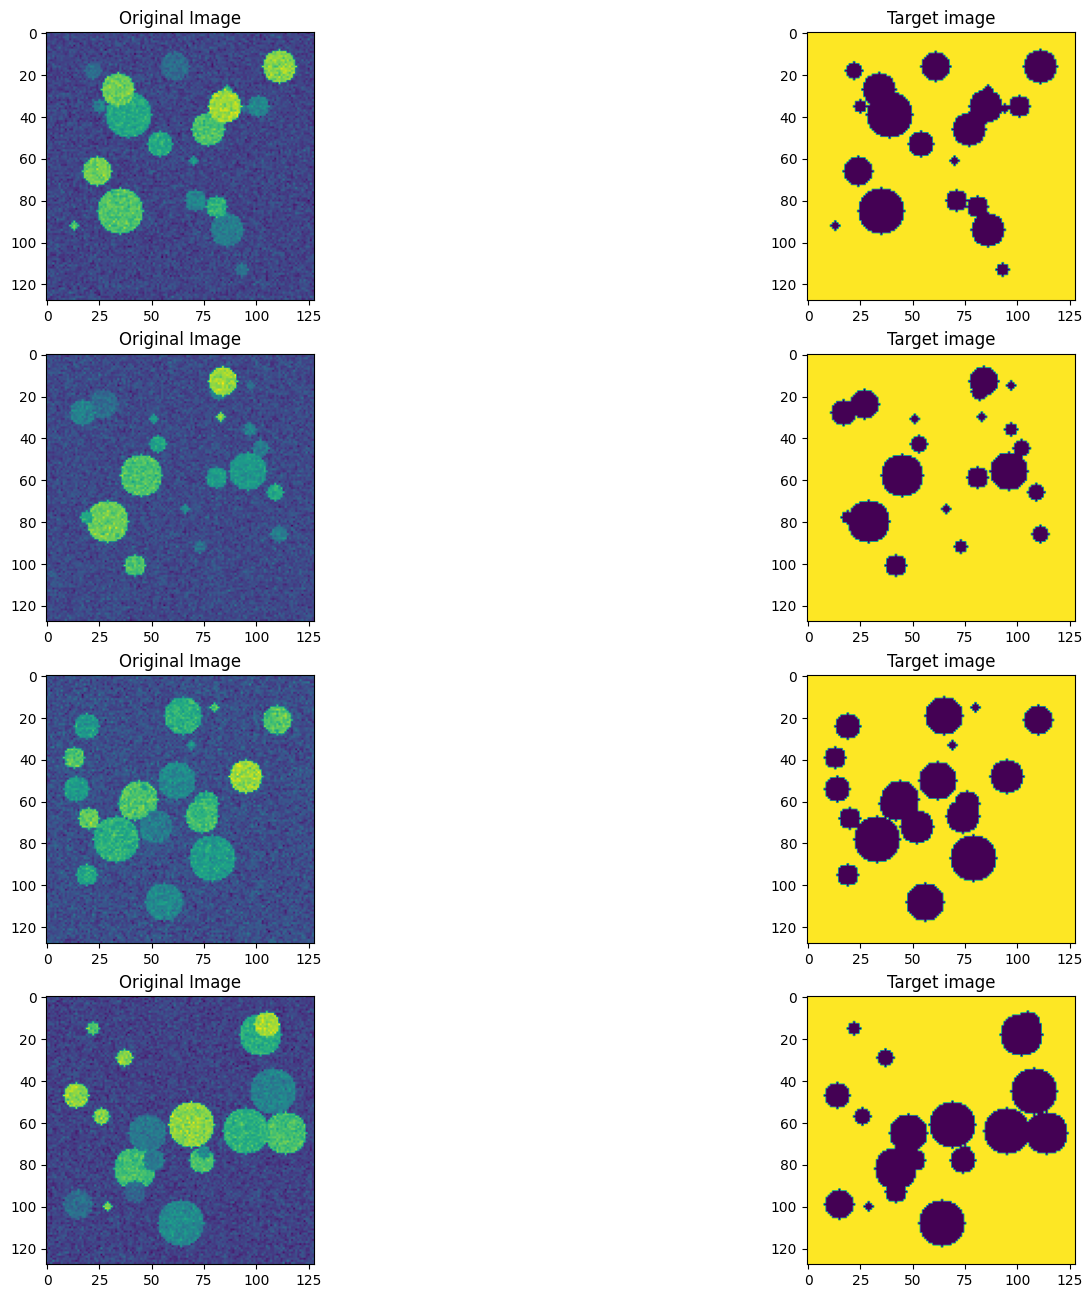

In [31]:
def show_examples(datax, datay, num_examples=4):
    fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Original Image")
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Target image")
    plt.show()

show_examples(x_train_128, y_train_128)